# The Forgotten Books:  Unseen Species Models and the Survival of Medieval Literature
## Supporting code 

The code in the present notebook relies on the `copia` software package (for Python 3.6+), which is available from [Github](https://github.com/mikekestemont/copia) and documented [here](https://copia.readthedocs.io/en/latest/). A recent version can be installed from PyPI (`>>> pip install copia`). In the cell below, we import the other modules on which the software depends:

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(543251) # control random seed

import copia.utils as u
from copia.richness import *
from copia.hill import hill_numbers
from copia.utils import survival_ratio
from copia.utils import evenness
from copia.plot import accumulation_curve
from copia.plot import multi_kde
from copia.plot import survival_errorbar
from copia.plot import evenness_plot
from copia.plot import density
from copia.plot import hill_plot

plt.style.use('science')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.minor.left'] = False

## Data

This repository ships with all datasets used in the study, which can be found as spreadsheets under `datasets/master`. We load the individual assemblages and convert them to `pandas` DataFrames:

In [2]:
lits = {}
for fn in sorted(glob.glob('../datasets/master/*.xlsx')):
    if 'anglo-norman' in fn:
        continue
    df = pd.read_excel(fn, engine='openpyxl').dropna(subset = ["title"])
    lang = os.path.basename(fn).replace('.xlsx', '').lower()
    lits[lang] = df[['title', 'signature', 'repository']]

Next, we extract a high-number of high-level statistics from these datasets ($f_1$, $f_2$, $n$, and $S$, as well as the number of distinct repositories), which we cast to what is known as "abundance data" in ecology:

In [3]:
stats = []
for lit, df in lits.items():
    abundance = u.to_abundance(df['title'])
    s = u.basic_stats(abundance)
    d = {'language': lit}
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    d['repo'] = len(set(df['repository']))
    stats.append(d)

stats

[{'language': 'dutch', 'f1': 45, 'f2': 13, 'S': 75, 'n': 167, 'repo': 80},
 {'language': 'english', 'f1': 42, 'f2': 8, 'S': 69, 'n': 176, 'repo': 36},
 {'language': 'french', 'f1': 90, 'f2': 21, 'S': 222, 'n': 1473, 'repo': 234},
 {'language': 'german', 'f1': 36, 'f2': 19, 'S': 128, 'n': 1088, 'repo': 389},
 {'language': 'icelandic', 'f1': 44, 'f2': 28, 'S': 117, 'n': 295, 'repo': 12},
 {'language': 'irish', 'f1': 69, 'f2': 54, 'S': 188, 'n': 449, 'repo': 15}]

We add similar statistics for the union of the datasets, but do not include the number of repositories (because these have not been disambiguated across the assemblages):

In [4]:
stats_df = pd.DataFrame(stats)
stats_df['language'] = stats_df['language'].str.lower()
stats_df.loc[len(stats_df)] = ['all'] + list(stats_df[['f1', 'f2', 'S', 'n']].sum()) + [None]
stats_df = stats_df.set_index('language')
stats_df

,f1,f2,S,n,repo
language,,,,,
dutch,45,13,75,167,80
english,42,8,69,176,36
french,90,21,222,1473,234
german,36,19,128,1088,389
icelandic,44,28,117,295,12
irish,69,54,188,449,15
all,326,143,799,3648,None


## Union

We start by analyzing the union of the six datasets. We explicitly add a language tag to each work's title, to avoid naming conflicts:

In [5]:
dfs = []
for lang, df in lits.items():
    df['title'] = [t+'_'+lang for t in df['title']]
    dfs.append(df)
    
df_all = pd.concat(dfs, ignore_index=True)
df_all

,title,signature,repository
0,Aiol (1)_dutch,"Leiden, UB, BPL 1049; Brussel, KB, IV 816","Leiden, UB ; Brussel, KB"
1,Aiol (2)_dutch,"Breda, Arch. Begijnhof, z.s.","Breda, Arch. Begijnhof"
2,Alexanders geesten_dutch,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek"
3,Alexanders geesten_dutch,"Gent, UB, 2749,6","Gent, UB"
4,Alexanders geesten_dutch,"Leiden, UB, Ltk. 1196","Leiden, UB"
...,...,...,...
3643,Lorgaireacht an tSoidhigh Naomhtha_irish,Royal Irish Academy (Dublin) D iv 2,"Royal Irish Academy, Dublin"
3644,Lorgaireacht an tSoidhigh Naomhtha_irish,Bodleian (Oxford) Rawlinson B 512,"Bodleian Library, Oxford"
3645,Stair na Lumbardach_irish,UCC Book of Lismore,"University College Library, Cork"
3646,[Seven Wise Masters]_irish,Trinity College Library MS 667,"Trinity College, Dublin"


We convert this information to abundance data, using a utility function from `copia`:

In [6]:
abundance = u.to_abundance(df_all['title'])

We'll store all resulting assets to an `outputs` directory:

In [7]:
try:
    os.mkdir('../outputs')
except FileExistsError:
    pass

First, we obtain point estimates for the survival of the numbers of works ("Chao1") and documents ("minsample"):

In [8]:
print('original # works:', diversity(abundance, method='chao1'))
print('original # documents:', diversity(abundance, method='minsample'))

original # works: 1170.492543092872
original # documents: 40614.31536631537


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19520926261066052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


We continue with plotting density curves that show the bootstrap estimates (and associated quantiles) for the diversity estimates as survival ratios. Note that `survival_ratio()` converts the initial estimate to a survival rate, i.e. by taking the ratio of the estimates over the observed $S$ and $n$ respectively.

In [9]:
wsurvival_all = survival_ratio(abundance, method='chao1', n_iter=10000)

100%|██████████| 10000/10000 [00:01<00:00, 8680.22it/s]


In [10]:
run ../../copia/copia/plot.py

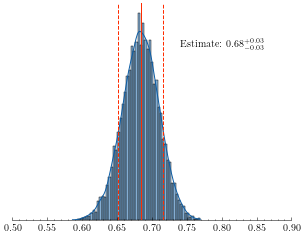

In [11]:
ax = density(wsurvival_all, figsize=(5, 4), xlim=(0.5, 0.9))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylabel(None)
ax.spines['left'].set_visible(False)
plt.savefig('../outputs/dens_works.pdf')

In [12]:
dsurvival_all = survival_ratio(abundance, method='minsample', n_iter=10000)

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19520926261066052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 0/10000 [00:00<?, ?it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17846036067385285 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 4/10000 [00:00<09:04, 18.36it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10939853521176701 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21746281333435036 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance 

  1%|          | 61/10000 [00:01<04:25, 37.41it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17104479498902947 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16774036207243626 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17668569995930739 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 66/10000 [00:01<04:16, 38.66it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17847595503644698 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: 

  1%|▏         | 126/10000 [00:03<03:53, 42.37it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12263417960275547 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14675843470377004 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|▏         | 131/10000 [00:03<03:47, 43.37it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1687549869348004 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|▏         | 136/10000 [00:03<03:47, 43.39it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26862823072042374 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont

  2%|▏         | 191/10000 [00:04<03:50, 42.49it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21700300854354282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10743539828490611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11373429668128665 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16368115958812268 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 196/10000 [00:04<03:49, 42.68it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning

  3%|▎         | 251/10000 [00:06<03:49, 42.39it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19673325750409276 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14706868743724044 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 256/10000 [00:06<03:46, 43.00it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19735215012769913 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1961182066852416 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning:

  4%|▍         | 376/10000 [00:09<03:42, 43.19it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20426849146224413 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11627200412840466 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1521911047921094 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 381/10000 [00:09<03:45, 42.67it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1159789215098499 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 386/10000 [00:09<03:39, 43.85it/s]/Users/mikekestemont/

  4%|▍         | 441/10000 [00:10<03:52, 41.18it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2552162154015605 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 446/10000 [00:10<03:50, 41.38it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16487303428129962 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1412510799464144 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▍         | 451/10000 [00:10<03:45, 42.41it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1680387437227182 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/G

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19982332583822426 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24609695579874824 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1193803239866611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 526/10000 [00:12<03:35, 43.91it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20873940754290743 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15306178375158197 >

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1796816648075037 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 601/10000 [00:14<03:29, 44.76it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21177042492490727 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 606/10000 [00:14<03:31, 44.42it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12957471183108282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20916195922836778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 611/10000 [00:14<03:34, 43.80it/s]/Users/mikekestemont

  7%|▋         | 686/10000 [00:16<03:34, 43.51it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2052589797112887 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18929538753309316 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 691/10000 [00:16<03:33, 43.63it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1780988239634098 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16320079011256894 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 696/10000 [00:16<03:30, 44.25it/s]/Users/mikekestemont/

  8%|▊         | 776/10000 [00:18<03:37, 42.43it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19169365156540152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2528204403397467 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10415988418299094 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  8%|▊         | 781/10000 [00:18<03:38, 42.14it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15440013004354114 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning:

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15253120462239167 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▊         | 856/10000 [00:20<03:33, 42.80it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19556308463234018 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23300252682747669 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▊         | 861/10000 [00:20<03:28, 43.80it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12328376689856668 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▊         | 866/10000 [00:20<03:29, 43.68it/s]/Users/mikekestemon

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12828084526609018 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17241500141517463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1076/10000 [00:25<03:20, 44.41it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13958547985657788 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1081/10000 [00:25<03:20, 44.48it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16672444048526813 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarni

 12%|█▏        | 1191/10000 [00:27<03:15, 45.11it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12593667427699984 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1196/10000 [00:27<03:18, 44.28it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14328240970189654 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1201/10000 [00:28<03:16, 44.84it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1273567694479425 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1206/10000 [00:28<03:15, 44.92it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23536811913709244 > 0.1
  warnings.warn(f"Tolerance criterion not met

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14796280234804726 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1316/10000 [00:30<03:14, 44.58it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22679431080996437 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14793773249857622 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1321/10000 [00:30<03:14, 44.64it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24450086889464728 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1326/10000 [00:30<03:14, 44.66it/s]/Users/mikekeste

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16982750716579176 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1436/10000 [00:33<03:15, 43.87it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2135544271695835 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11220529359934517 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2356947154385125 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1446/10000 [00:33<03:14, 43.98it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11051531522298319 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▌        | 1561/10000 [00:36<03:08, 44.65it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21922210353659466 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2199932133717084 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11273454445381503 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▌        | 1566/10000 [00:36<03:11, 44.02it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarnin

 17%|█▋        | 1691/10000 [00:39<03:07, 44.36it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24470073698284978 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11147687896482239 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20922657346818596 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1706/10000 [00:39<03:05, 44.66it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2097431285174025 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1711/10000 [00:39<03:03, 45.14it/s]/Users/mikekestem

 18%|█▊        | 1841/10000 [00:42<03:00, 45.11it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17329755791524803 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13164986583706195 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1846/10000 [00:42<03:01, 45.01it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12286176836278173 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1877024137575063 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▊        | 1856/10000 [00:42<03:02, 44.60it/s]/Users/mikekestem

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21382379150691122 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1971/10000 [00:45<02:54, 45.89it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11268435871170368 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1976/10000 [00:45<02:58, 44.86it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12145444508132641 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10276087528745848 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1981/10000 [00:45<02:57, 45.15it/s]/Users/mikekeste

 21%|██        | 2112/10000 [00:48<02:56, 44.73it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1971541796810925 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2122/10000 [00:48<02:52, 45.70it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15725719456440856 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██▏       | 2127/10000 [00:48<02:55, 44.80it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.200863924587793 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██▏       | 2132/10000 [00:49<02:54, 45.04it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19332621096782532 > 0.1
  warnings.warn(f"Tolerance criterion not met: 

 23%|██▎       | 2263/10000 [00:51<02:56, 43.89it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12290844140989066 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2268/10000 [00:52<02:53, 44.45it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2147089910986324 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2283/10000 [00:52<02:53, 44.53it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25898711420450127 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2288/10000 [00:52<02:52, 44.74it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17427859809959045 > 0.1
  warnings.warn(f"Tolerance criterion not met

 24%|██▍       | 2433/10000 [00:55<02:45, 45.73it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19983907411733526 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1727358926409579 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 24%|██▍       | 2438/10000 [00:55<02:44, 45.99it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11946306498339254 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 24%|██▍       | 2443/10000 [00:55<02:47, 45.10it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1515377261221147 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemo

 26%|██▌       | 2558/10000 [00:58<02:47, 44.39it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11520363549152535 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11307230118472944 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▌       | 2563/10000 [00:58<02:47, 44.37it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14148498265922171 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▌       | 2568/10000 [00:58<02:44, 45.30it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14413886717738933 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekeste

 29%|██▉       | 2878/10000 [01:05<02:49, 42.13it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13812405174940068 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 29%|██▉       | 2883/10000 [01:05<02:45, 43.08it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14307271554662293 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 29%|██▉       | 2888/10000 [01:05<02:41, 44.14it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1644988752213976 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 29%|██▉       | 2893/10000 [01:06<02:40, 44.21it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11173122859509022 > 0.1
  warnings.warn(f"Tolerance criterion not met

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23615767593855708 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3114/10000 [01:10<02:30, 45.75it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19346705643147288 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16487284323102358 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███▏      | 3139/10000 [01:11<02:29, 45.87it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24595041021257202 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 32%|███▏      | 3154/10000 [01:11<02:31, 45.17it/s]/Users/mikekeste

 34%|███▎      | 3365/10000 [01:16<02:38, 41.89it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10310538250996615 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11399572280652137 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 34%|███▍      | 3375/10000 [01:16<02:34, 42.90it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2104465482825617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17613842380433198 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 34%|███▍      | 3390/10000 [01:17<02:27, 44.82it/s]/Users/mikekestem

 36%|███▌      | 3610/10000 [01:21<02:20, 45.48it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10642562782868481 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 36%|███▌      | 3615/10000 [01:22<02:23, 44.61it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10370186285399541 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 36%|███▋      | 3625/10000 [01:22<02:18, 46.07it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10704128414545266 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 36%|███▋      | 3630/10000 [01:22<02:19, 45.56it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22236876272381778 > 0.1
  warnings.warn(f"Tolerance criterion not me

 41%|████      | 4055/10000 [01:31<02:17, 43.29it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2607983699426768 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 41%|████      | 4060/10000 [01:31<02:13, 44.45it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1692876310680731 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 41%|████      | 4065/10000 [01:32<02:11, 45.00it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14034478264693462 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 41%|████      | 4080/10000 [01:32<02:13, 44.25it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12591918006091873 > 0.1
  warnings.warn(f"Tolerance criterion not met:

 43%|████▎     | 4300/10000 [01:37<02:07, 44.88it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18617557257130102 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 43%|████▎     | 4320/10000 [01:37<02:07, 44.43it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13602251564952894 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11220380234135519 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 43%|████▎     | 4340/10000 [01:38<02:02, 46.37it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19550449467260478 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 43%|████▎     |

 46%|████▋     | 4627/10000 [01:44<01:58, 45.47it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21655729292888282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▋     | 4632/10000 [01:44<01:57, 45.62it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11584399490493524 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▋     | 4637/10000 [01:44<01:59, 44.85it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14538779631038778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▋     | 4642/10000 [01:44<01:58, 45.12it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.267758873744242 > 0.1
  warnings.warn(f"Tolerance criterion not met:

 50%|████▉     | 4952/10000 [01:51<01:54, 44.20it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2175633415017728 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|████▉     | 4957/10000 [01:51<01:54, 44.21it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14509366675156343 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|████▉     | 4992/10000 [01:52<01:48, 46.11it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20816581080725882 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|████▉     | 4997/10000 [01:52<01:51, 45.01it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20367874129533448 > 0.1
  warnings.warn(f"Tolerance criterion not met

 56%|█████▌    | 5605/10000 [02:05<01:36, 45.74it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1025866319087072 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17999071994654514 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 56%|█████▌    | 5610/10000 [02:06<01:38, 44.57it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16458887880344264 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 56%|█████▌    | 5620/10000 [02:06<01:41, 43.28it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22046792037417617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 56%|█████▋    | 

 59%|█████▉    | 5886/10000 [02:12<01:34, 43.70it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23850432210747385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 59%|█████▉    | 5896/10000 [02:12<01:33, 43.92it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2071057417515476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 59%|█████▉    | 5906/10000 [02:12<01:31, 44.66it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12436241471641551 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 59%|█████▉    | 5921/10000 [02:13<01:32, 43.99it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21763628986354888 > 0.1
  warnings.warn(f"Tolerance criterion not met

/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14636840798812045 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 62%|██████▏   | 6226/10000 [02:19<01:26, 43.50it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19091612826377968 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2244123418190611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21297031798621902 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 62%|██████▏   | 6236/10000 [02:19<01:27, 43.20it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarnin

 67%|██████▋   | 6697/10000 [02:29<01:11, 46.13it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1883828902532514 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 67%|██████▋   | 6702/10000 [02:30<01:10, 46.67it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11881846115102235 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 67%|██████▋   | 6712/10000 [02:30<01:11, 46.10it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24916630473308032 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 67%|██████▋   | 6722/10000 [02:30<01:10, 46.64it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2445724882745708 > 0.1
  warnings.warn(f"Tolerance criterion not met:

 76%|███████▌  | 7599/10000 [02:49<00:55, 43.47it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2460519002388537 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▌  | 7619/10000 [02:50<00:53, 44.66it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13806062798084895 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19664569549877342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▋  | 7634/10000 [02:50<00:52, 44.77it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23927399648891878 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▋  | 

 80%|███████▉  | 7984/10000 [02:58<00:43, 45.97it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2529584255762529 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|███████▉  | 7994/10000 [02:58<00:44, 44.86it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16419199769552506 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|████████  | 8004/10000 [02:58<00:43, 45.44it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1215966561840105 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|████████  | 8024/10000 [02:59<00:42, 46.31it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2082057334300771 > 0.1
  warnings.warn(f"Tolerance criterion not met: 

 84%|████████▎ | 8361/10000 [03:06<00:35, 46.65it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17201605612626736 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 84%|████████▎ | 8366/10000 [03:06<00:35, 45.49it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1878614104580265 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 84%|████████▎ | 8371/10000 [03:06<00:35, 46.14it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17816751555164956 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 84%|████████▍ | 8391/10000 [03:07<00:34, 45.98it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24079997564786026 > 0.1
  warnings.warn(f"Tolerance criterion not met

 94%|█████████▍| 9438/10000 [03:30<00:12, 45.23it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12181620485898748 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15201579441963986 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 94%|█████████▍| 9448/10000 [03:30<00:12, 44.33it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1982951011877958 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 95%|█████████▍| 9463/10000 [03:30<00:11, 45.26it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23844741877564957 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 95%|█████████▍| 

 98%|█████████▊| 9849/10000 [03:39<00:03, 45.21it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16201927749443712 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2517754886794137 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 99%|█████████▊| 9859/10000 [03:39<00:03, 45.51it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2606650077404993 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 99%|█████████▊| 9864/10000 [03:39<00:03, 45.09it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2066559784761921 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/mikekestemon

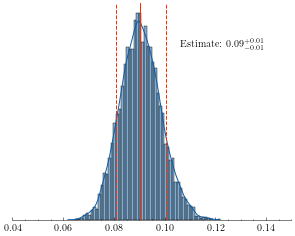

In [13]:
ax = density(dsurvival_all, figsize=(5, 4), xlim=(0.04, 0.15))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylabel(None)
ax.spines['left'].set_visible(False)
plt.savefig('../outputs/dens_docs.pdf')

Next, we plot the so-called **species accumulation curve** for the union of the datasets (which will take a while to run). This curve is relevant for specialists of medieval literature, as it gives an indication of the rate at which we might still be discovering new works in the future, by sighting more documents (provided these witnesses have yet not been lost beyond retrieval):

In [14]:
max_steps = 60000 # this number already takes into account the minsample-estimate
accumulation = species_accumulation(abundance, max_steps=max_steps)

100%|██████████| 100/100 [42:10<00:00, 25.30s/it]


To this plot, we will later add a kernel-density estimate that shows the bootstrapped estimates from the `minsample` estimate (on the secondary, horizontal axis). Informally, the resulting blob corresponds to the area where we expect the asymptotic curve from the previous to start saturating. During the `minsample`'s bootstrap procedure initiated in the cell below, `UserWarning`s may sporadically appear in cases where the optimization didn't satisfactorily converge. This is expected behavior.)

In [15]:
minsample_est = diversity(abundance, method='minsample', 
                          solver='fsolve', CI=True, n_iter=10000)

/Users/mikekestemont/GitRepos/copia/copia/richness.py:424: RuntimeWarning: overflow encountered in exp
  v = lambda x: np.exp(x * (2 * f2 / f1))
/Users/mikekestemont/anaconda3/envs/cop/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mikekestemont/GitRepos/copia/copia/richness.py:437: UserWarning: Tolerance criterion not met via fsolve: inf > 0.1-> backing off to grid-solver.
  warnings.warn(msg)
/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19520926261066052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  0%|          | 1/10000 [00:00<18:22,  9.07it/s]

Diff_intersect: 

  0%|          | 5/10000 [00:00<07:25, 22.45it/s]

inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14234643200870778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10582458103453973 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23300252682747669 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20919353600402246 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1776572068392852 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  0%|          | 8/10000 [00:00<06:39, 25.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22808862897454674 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 11/10000 [00:00<06:19, 26.32it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16982750716579176 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  0%|          | 14/10000 [00:00<06:21, 26.16it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2536532971853376 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21142946646523342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 17/10000 [00:00<06:15, 26.59it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2139268229720983 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21655729292888282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 20/10000 [00:00<06:11, 26.88it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11752398958560661 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14161880683423078 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 23/10000 [00:00<06:09, 27.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16070224555005552 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 27/10000 [00:01<05:50, 28.43it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24287345592802012 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10449302785855252 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13819350117501017 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  0%|          | 31/10000 [00:01<05:37, 29.55it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12733100285231558 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12365400614362443 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  0%|          | 35/10000 [00:01<05:22, 30.91it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14976161142476485 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10656832897620916 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  0%|          | 39/10000 [00:01<05:08, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14226237173261325 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11009218955950928 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  0%|          | 43/10000 [00:01<04:59, 33.21it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16238893159061263 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2039593132039954 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  0%|          | 47/10000 [00:01<05:05, 32.55it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24450086889464728 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22460353917813336 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  1%|          | 51/10000 [00:01<05:01, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13651618315361702 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 55/10000 [00:01<04:57, 33.46it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1570144485167475 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  1%|          | 59/10000 [00:01<04:58, 33.30it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10768051173181448 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13542307637362683 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20964130732409103 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1533603114048674 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 63/10000 [00:02<05:02, 32.85it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20951339429211657 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15083014848096354 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 67/10000 [00:02<05:02, 32.87it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12978300306122037 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2139568902184692 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14350896029918658 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 71/10000 [00:02<05:01, 32.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16374833025020052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21952874599901406 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  1%|          | 75/10000 [00:02<05:04, 32.62it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23083223343110149 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17846036067385285 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14154679840430617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16320079011256894 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 79/10000 [00:02<05:01, 32.95it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13787775548644277 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15338435220019164 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2257101244185833 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17197272315479495 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 83/10000 [00:02<04:57, 33.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20636517781804287 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14328240970189654 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2158732184989276 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 87/10000 [00:02<05:00, 33.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14226959740153688 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13552252866338677 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25752890560852393 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 91/10000 [00:02<05:04, 32.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22574767660807993 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15013589037152997 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15641196353317355 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  1%|          | 95/10000 [00:03<05:06, 32.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14130261548052658 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1014928393296941 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19573815537842165 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  1%|          | 99/10000 [00:03<04:59, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20201205571447645 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21532867003315914 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  1%|          | 103/10000 [00:03<04:56, 33.37it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22251387886626617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1823435031446934 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 107/10000 [00:03<04:53, 33.71it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12097675564291421 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15576068508471508 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11854208854038006 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19838784194143955 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 111/10000 [00:03<05:00, 32.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25050312002713326 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12812876436601073 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  1%|          | 115/10000 [00:03<04:59, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  1%|          | 119/10000 [00:03<04:57, 33.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10795699372283707 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  1%|          | 123/10000 [00:03<04:55, 33.45it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23536811913709244 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23660229956021794 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  1%|▏         | 127/10000 [00:04<04:58, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21297031798621902 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  1%|▏         | 131/10000 [00:04<05:00, 32.81it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11373429668128665 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  1%|▏         | 135/10000 [00:04<04:57, 33.15it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10867807398244622 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12346125305612077 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22179891447194677 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|▏         | 139/10000 [00:04<05:02, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2095780934769209 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  1%|▏         | 143/10000 [00:04<04:58, 32.98it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17893823636677553 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17999071994654514 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2103786740672149 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|▏         | 147/10000 [00:04<05:03, 32.46it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20245240902750083 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1528360400288875 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19822083971394022 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 151/10000 [00:04<04:59, 32.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  2%|▏         | 155/10000 [00:04<04:54, 33.38it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15803054761909152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14985139503278333 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15020747676408064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 159/10000 [00:05<04:56, 33.23it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2122552069613448 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19289584118996572 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  2%|▏         | 163/10000 [00:05<04:56, 33.20it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1042936080139043 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21636331250010699 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  2%|▏         | 167/10000 [00:05<04:51, 33.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22677722561729752 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22582391916876077 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21763628986354888 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 171/10000 [00:05<04:58, 32.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21846770292631845 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 175/10000 [00:05<05:00, 32.67it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10324216985554813 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21388016892069572 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1009725471967613 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  2%|▏         | 179/10000 [00:05<04:59, 32.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20916195922836778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 183/10000 [00:05<04:58, 32.91it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23435837601118692 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2060813870784841 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10743539828490611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 187/10000 [00:05<05:00, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1564148322058827 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  2%|▏         | 191/10000 [00:05<04:52, 33.54it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20407487657666934 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13152244171214988 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18251145734393504 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 195/10000 [00:06<04:52, 33.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15724502956982178 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  2%|▏         | 199/10000 [00:06<05:01, 32.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12134915374008415 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21389211456062185 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13380947943460342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 203/10000 [00:06<04:59, 32.76it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1283451173994763 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1838900129450849 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  2%|▏         | 207/10000 [00:06<04:56, 33.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1695660015948306 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19683067360074347 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 211/10000 [00:06<04:56, 33.07it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11464064701613097 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24467476224526763 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12871034272575343 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21690510764165083 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 215/10000 [00:06<04:55, 33.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21640021762505057 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21072327737056185 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21365777682512999 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10255068651167676 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 219/10000 [00:06<04:57, 32.92it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17781784698945557 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15599781981109118 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  2%|▏         | 223/10000 [00:06<04:53, 33.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24831530965093407 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19391886748235265 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16525482696943072 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 227/10000 [00:07<04:58, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11478444111344288 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  2%|▏         | 231/10000 [00:07<04:53, 33.33it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1971541796810925 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23234119960579847 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23747349966834008 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 235/10000 [00:07<04:55, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13033437744434195 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.207529897979839 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  2%|▏         | 239/10000 [00:07<04:54, 33.11it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20752404476934316 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15969814863274223 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21309381111041148 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 243/10000 [00:07<04:57, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20918539680042159 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 247/10000 [00:07<04:55, 33.02it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18039436658546038 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16068522861223755 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23678254453898262 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 251/10000 [00:07<04:54, 33.14it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1912093949285918 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2008435332991212 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17427859809959045 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 255/10000 [00:07<04:57, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1952483203740485 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  3%|▎         | 259/10000 [00:08<04:54, 33.13it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11745893884381076 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14805649567551882 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2059902652154051 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 263/10000 [00:08<04:55, 32.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1771059600805529 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1749952219406623 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 267/10000 [00:08<04:51, 33.36it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1982951011877958 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18428929939454974 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12315023032624595 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 271/10000 [00:08<04:48, 33.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14495000968054228 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 275/10000 [00:08<04:50, 33.50it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1861227305171269 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21995334031089442 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23917454669935978 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16445827330881002 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 279/10000 [00:08<04:56, 32.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2052589797112887 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2177854805950119 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 283/10000 [00:08<04:56, 32.80it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23896972309194098 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2198750653260504 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 287/10000 [00:08<04:52, 33.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22217412866484665 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 291/10000 [00:09<04:55, 32.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15440013004354114 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 295/10000 [00:09<04:55, 32.89it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19460946208801033 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1966487952713578 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 299/10000 [00:09<04:54, 32.97it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1802492177912427 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13226023825154698 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21382379150691122 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 303/10000 [00:09<04:58, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13158312811083306 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21187119155729306 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 307/10000 [00:09<04:56, 32.72it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22990424076579075 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1511719654636181 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 311/10000 [00:09<04:55, 32.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2202132448874181 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 315/10000 [00:09<04:54, 32.85it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2123489103069005 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12828084526609018 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1448356020009669 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 319/10000 [00:09<04:56, 32.67it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19020139277108683 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24649296900952322 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  3%|▎         | 323/10000 [00:09<04:52, 33.06it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14839469747039402 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13356405099239055 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19506827295026596 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2071057417515476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 327/10000 [00:10<05:00, 32.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15727936215989757 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21623756645203684 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11035044539130467 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 331/10000 [00:10<05:04, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1011246271782511 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22730692186269152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 335/10000 [00:10<05:00, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21072820214794774 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11681270319058967 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 339/10000 [00:10<04:59, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.210284609665905 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10340113043275778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  3%|▎         | 343/10000 [00:10<04:58, 32.37it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2244123418190611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18732064922824065 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23101245180623664 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  3%|▎         | 347/10000 [00:10<04:59, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19340131056742393 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17481570570362237 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▎         | 351/10000 [00:10<04:55, 32.63it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20639522399051202 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14496341236917942 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24230752815947199 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22473724442625098 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▎         | 355/10000 [00:10<04:58, 32.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22751048364807502 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10965203525938705 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▎         | 359/10000 [00:11<04:58, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14288473887063446 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▎         | 363/10000 [00:11<04:53, 32.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24470073698284978 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22873185210119118 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  4%|▎         | 367/10000 [00:11<04:56, 32.50it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16764673640955152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13762811004198738 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22288831557762023 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  4%|▎         | 371/10000 [00:11<04:58, 32.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20775549400877935 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13386018823439372 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20640236930375977 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 375/10000 [00:11<04:54, 32.64it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15646618282244162 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14927235004506656 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13914521183050965 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 379/10000 [00:11<04:53, 32.75it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12630977977369184 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14840029708921065 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  4%|▍         | 383/10000 [00:11<04:51, 32.99it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1725359926094825 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21695572005228314 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2257949635222758 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 387/10000 [00:11<04:57, 32.28it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14876933803952852 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1521911047921094 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12307510934988386 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 391/10000 [00:12<04:58, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14413886717738933 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 395/10000 [00:12<04:58, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11531630517583835 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  4%|▍         | 399/10000 [00:12<04:56, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13096380318984302 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 403/10000 [00:12<04:56, 32.32it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25222854600269784 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2222858775385248 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2145891229101835 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 407/10000 [00:12<04:57, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2340878328823237 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 411/10000 [00:12<05:00, 31.93it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2379202462534522 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  4%|▍         | 415/10000 [00:12<04:56, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12590129267118755 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11881846115102235 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  4%|▍         | 419/10000 [00:12<04:59, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12286176836278173 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 423/10000 [00:13<05:00, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15815262963860732 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14706868743724044 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 427/10000 [00:13<04:59, 31.97it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11611414036633505 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  4%|▍         | 431/10000 [00:13<04:57, 32.20it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.101467586587205 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.185507994737236 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20371619578691025 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  4%|▍         | 435/10000 [00:13<04:55, 32.34it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21125744016444514 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  4%|▍         | 439/10000 [00:13<04:53, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  4%|▍         | 443/10000 [00:13<04:49, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2285272812250696 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 447/10000 [00:13<04:46, 33.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19120917482814548 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10156841220486967 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  5%|▍         | 451/10000 [00:13<04:46, 33.31it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18069895318421914 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  5%|▍         | 455/10000 [00:14<04:46, 33.28it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24420696528977714 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15117666482274217 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  5%|▍         | 459/10000 [00:14<04:53, 32.51it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2279478770624337 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25809977678181895 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▍         | 463/10000 [00:14<04:52, 32.63it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20606846213740937 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12919374219745805 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17650896937084326 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▍         | 467/10000 [00:14<04:57, 32.05it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18818679018659168 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20041706655229063 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12039540079786093 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▍         | 471/10000 [00:14<05:00, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17019397928106628 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  5%|▍         | 475/10000 [00:14<05:04, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18456631998697048 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13612903114244546 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▍         | 479/10000 [00:14<05:11, 30.56it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11267114233942266 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  5%|▍         | 483/10000 [00:14<05:01, 31.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2423860332037293 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1673709803244492 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14441794537469832 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▍         | 487/10000 [00:15<05:09, 30.76it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25671395937933994 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10713713717268547 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▍         | 491/10000 [00:15<05:10, 30.61it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12237444216862059 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1045686306870266 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▍         | 495/10000 [00:15<05:05, 31.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20425706551304756 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17244231293898338 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1841302990578697 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▍         | 499/10000 [00:15<05:02, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17354186397415106 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19658751573933841 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 503/10000 [00:15<05:03, 31.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16267041985884134 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18757107991859812 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11769554288457584 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 507/10000 [00:15<05:01, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2548788965214044 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 511/10000 [00:15<04:57, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21500340571947163 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1066773291777281 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 515/10000 [00:15<04:58, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12670097732825525 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 519/10000 [00:16<05:01, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24361369166490476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▌         | 523/10000 [00:16<05:03, 31.21it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14709843574200931 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13516231502489973 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1741578234377812 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2404267606925714 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 527/10000 [00:16<05:07, 30.83it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.251755678956215 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16650324285456009 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1526271122656908 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 531/10000 [00:16<05:10, 30.50it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18739541272589122 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15805412178360712 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15287473514854355 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  5%|▌         | 535/10000 [00:16<05:06, 30.87it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11652384514036385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  5%|▌         | 539/10000 [00:16<05:02, 31.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1969409170706058 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▌         | 543/10000 [00:16<05:04, 31.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17955867646560364 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11761679037317663 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  5%|▌         | 547/10000 [00:17<05:07, 30.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1520093328163057 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 551/10000 [00:17<05:01, 31.32it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1845354459965165 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11803249894092005 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1295333571424635 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 555/10000 [00:17<05:03, 31.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13699816038297286 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1346340388781755 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1235944676118379 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 559/10000 [00:17<05:05, 30.93it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24982794626157556 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10708528644681792 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 563/10000 [00:17<05:07, 30.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20030052799847908 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15984327329715597 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15162355639404268 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 567/10000 [00:17<05:04, 30.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12181620485898748 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2097431285174025 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 571/10000 [00:17<05:08, 30.54it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20697396815012326 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18701559767850995 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  6%|▌         | 575/10000 [00:17<05:03, 31.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18044465633556683 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17935393261177524 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 579/10000 [00:18<05:04, 30.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22177097894200415 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22020139565756836 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15918622830940876 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 583/10000 [00:18<05:09, 30.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1723885463716215 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15395906327921693 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18488368564430857 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 587/10000 [00:18<05:10, 30.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15392286951100687 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 591/10000 [00:18<05:07, 30.62it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15997648327993375 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  6%|▌         | 595/10000 [00:18<05:01, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15703609247611894 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  6%|▌         | 599/10000 [00:18<05:01, 31.19it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1638118917871907 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13792207662936562 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 603/10000 [00:18<05:01, 31.14it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20931629313054145 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1358433482764667 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  6%|▌         | 607/10000 [00:18<04:58, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15725719456440856 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 611/10000 [00:19<05:01, 31.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11174529560867086 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2135544271695835 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 615/10000 [00:19<05:06, 30.65it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18693854016601108 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1726538328366587 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14249618600570102 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2445724882745708 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 619/10000 [00:19<05:05, 30.75it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21750212928418478 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16646660686092218 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▌         | 623/10000 [00:19<04:59, 31.34it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10640557491933578 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  6%|▋         | 627/10000 [00:19<04:54, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  6%|▋         | 631/10000 [00:19<04:48, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19838455611170502 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▋         | 635/10000 [00:19<04:51, 32.15it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17763984435259772 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11420009876383119 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15789245299401955 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  6%|▋         | 639/10000 [00:19<04:50, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23043201802647673 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1612388061657839 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▋         | 643/10000 [00:20<04:51, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  6%|▋         | 647/10000 [00:20<05:03, 30.81it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18650480849464657 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10932740160933463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11977968529754435 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 651/10000 [00:20<04:57, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  7%|▋         | 655/10000 [00:20<04:52, 31.99it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18715141138636682 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11158842936038127 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  7%|▋         | 659/10000 [00:20<04:48, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2018980677366926 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1244508082363609 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1387321943166171 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 663/10000 [00:20<04:53, 31.85it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18277590695834078 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  7%|▋         | 667/10000 [00:20<04:44, 32.75it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10238531738104939 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16092446290986118 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21700300854354282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 671/10000 [00:20<04:48, 32.32it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1606532445312041 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13433462187094847 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1334484390936268 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18739419566099969 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 675/10000 [00:21<04:52, 31.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21672264498647564 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21119140177870577 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23267173481781356 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24458733002029476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 679/10000 [00:21<04:58, 31.21it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14821448589736974 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22047163498518785 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 683/10000 [00:21<05:09, 30.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15927508848199068 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  7%|▋         | 687/10000 [00:21<05:19, 29.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12510945935173368 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17520953696475772 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14936704509273113 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 691/10000 [00:21<05:10, 30.00it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16226772196387174 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12106913966363209 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.180659140658463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 695/10000 [00:21<05:05, 30.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20506913616463862 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  7%|▋         | 699/10000 [00:21<04:56, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2015250143240337 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19650107856432442 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 703/10000 [00:21<04:48, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  7%|▋         | 707/10000 [00:22<04:52, 31.73it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23843602609213121 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12153024181861838 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25546815657889965 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20784656418709346 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 711/10000 [00:22<04:52, 31.74it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1308192288634018 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2528204403397467 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10317106919774233 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 715/10000 [00:22<04:54, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17800616456679563 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17338446063149604 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 719/10000 [00:22<04:53, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21219332786404266 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 723/10000 [00:22<04:50, 31.92it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20490084036191547 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  7%|▋         | 727/10000 [00:22<04:56, 31.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18041521844588715 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21129332259079092 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  7%|▋         | 731/10000 [00:22<04:49, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14680403216607374 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  7%|▋         | 735/10000 [00:23<04:53, 31.52it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12854222352143552 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17790557231910498 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  7%|▋         | 739/10000 [00:23<04:54, 31.45it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22242905229359167 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13422947099388693 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19510039727174444 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 743/10000 [00:23<04:48, 32.06it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1860316692500419 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15986619865725515 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11062412675528321 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 747/10000 [00:23<04:49, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14290983860337292 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 751/10000 [00:23<04:45, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21818097459163255 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 755/10000 [00:23<04:46, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 759/10000 [00:23<04:42, 32.76it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16242007553773874 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21863174602276558 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13709436061708402 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  8%|▊         | 763/10000 [00:23<04:45, 32.35it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22064838968253753 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1871704707518802 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  8%|▊         | 767/10000 [00:23<04:45, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1600130686229022 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 771/10000 [00:24<04:45, 32.35it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19076233992291236 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23130494147153513 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 775/10000 [00:24<04:45, 32.27it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2266725220006265 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17142927312943357 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 779/10000 [00:24<04:48, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12494628831245791 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19672942504985258 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  8%|▊         | 783/10000 [00:24<04:46, 32.21it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23917352501666755 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 787/10000 [00:24<04:44, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18052303098738776 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 791/10000 [00:24<04:43, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 795/10000 [00:24<04:41, 32.69it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20295515446832724 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18388639140812302 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  8%|▊         | 799/10000 [00:24<04:45, 32.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2306072018600389 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24867014243409358 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  8%|▊         | 803/10000 [00:25<04:45, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17194458143603697 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  8%|▊         | 807/10000 [00:25<04:48, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15631600137658097 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1933959511006833 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  8%|▊         | 811/10000 [00:25<04:45, 32.18it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21614231445346377 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19784774967956764 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  8%|▊         | 815/10000 [00:25<04:44, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11860785378394212 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17677274328616477 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 819/10000 [00:25<04:49, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 823/10000 [00:25<04:49, 31.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.147052633506064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 827/10000 [00:25<04:50, 31.59it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10441858772901469 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22456233676621196 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11307230118472944 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  8%|▊         | 831/10000 [00:25<04:48, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16399399200781772 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  8%|▊         | 835/10000 [00:26<04:45, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22749136912898393 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 839/10000 [00:26<04:48, 31.74it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16898026316539472 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11353274283374049 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21473687296293065 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  8%|▊         | 843/10000 [00:26<04:52, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22860182012937003 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  8%|▊         | 847/10000 [00:26<04:47, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22644965380914073 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20697347691111645 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▊         | 851/10000 [00:26<04:47, 31.80it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14952092959447327 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  9%|▊         | 855/10000 [00:26<04:46, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16831603201171674 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16055238230273972 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▊         | 859/10000 [00:26<04:47, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15046194165870475 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▊         | 863/10000 [00:27<04:45, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10270569923795847 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▊         | 867/10000 [00:27<04:42, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20241410621019895 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  9%|▊         | 871/10000 [00:27<04:41, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22578628620613017 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2222953724767649 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 875/10000 [00:27<04:42, 32.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17940280918992357 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  9%|▉         | 879/10000 [00:27<04:43, 32.18it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2147673658319036 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1530554589626263 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 883/10000 [00:27<04:42, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21589859814048395 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10574151940363663 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 887/10000 [00:27<04:45, 31.94it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15475598892044218 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2353704604338418 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  9%|▉         | 891/10000 [00:27<04:45, 31.87it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20281648644595407 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16898965762266016 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 895/10000 [00:27<04:44, 31.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1790696892376218 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13266516335170309 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


  9%|▉         | 899/10000 [00:28<04:46, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  9%|▉         | 903/10000 [00:28<04:45, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17730091199518938 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17415382932631474 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 907/10000 [00:28<04:48, 31.48it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12813722205555678 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2404866217439121 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 911/10000 [00:28<04:44, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14178953066493705 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 915/10000 [00:28<04:45, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1328113253484844 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 919/10000 [00:28<04:42, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1780988239634098 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24179100877972814 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 923/10000 [00:28<04:38, 32.65it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14602793877384102 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2322155496913183 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 927/10000 [00:28<04:41, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19465053989551961 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13622317363297043 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 931/10000 [00:29<04:41, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2288692612091836 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  9%|▉         | 935/10000 [00:29<04:36, 32.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


  9%|▉         | 939/10000 [00:29<04:41, 32.20it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19228039067547797 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25031163881067187 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1595724595890715 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 943/10000 [00:29<04:46, 31.58it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11358606310022878 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20863660320719646 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10673290630620613 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


  9%|▉         | 947/10000 [00:29<04:48, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 951/10000 [00:29<04:43, 31.93it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10895676783275121 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 955/10000 [00:29<04:44, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24000133253866807 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|▉         | 959/10000 [00:29<04:42, 31.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15124070619731356 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1727358926409579 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|▉         | 963/10000 [00:30<04:44, 31.73it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13055290116335527 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11931548210213805 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21287919719361525 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|▉         | 967/10000 [00:30<04:44, 31.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20903717392775434 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 971/10000 [00:30<04:44, 31.74it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19987390702226548 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25158892212130013 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19381036313643563 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 10%|▉         | 975/10000 [00:30<04:41, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 979/10000 [00:30<04:40, 32.20it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2086690933929276 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17556501741637476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|▉         | 983/10000 [00:30<04:39, 32.21it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18852276751385943 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 987/10000 [00:30<04:42, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23562134566418536 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 991/10000 [00:30<04:38, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12631053348013666 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 10%|▉         | 995/10000 [00:31<04:37, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14227033888073493 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13854264349447476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 10%|▉         | 999/10000 [00:31<04:39, 32.19it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11522027578848792 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10384581679272742 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21088766130469594 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 10%|█         | 1003/10000 [00:31<04:39, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20370738246128894 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|█         | 1007/10000 [00:31<04:38, 32.32it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19483534963092097 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24632599168035085 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 10%|█         | 1011/10000 [00:31<04:36, 32.50it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10412309375442419 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22715731312655407 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|█         | 1015/10000 [00:31<04:37, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|█         | 1019/10000 [00:31<04:39, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15864511870404385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|█         | 1023/10000 [00:31<04:42, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|█         | 1027/10000 [00:32<04:37, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|█         | 1031/10000 [00:32<04:35, 32.56it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11124717851816968 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 10%|█         | 1035/10000 [00:32<04:36, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11817106987109582 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 10%|█         | 1039/10000 [00:32<04:37, 32.34it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13228443353636976 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16374489473582798 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 10%|█         | 1043/10000 [00:32<04:37, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11870567381993169 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 10%|█         | 1047/10000 [00:32<04:38, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1051/10000 [00:32<04:36, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21884698287249194 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1055/10000 [00:32<04:38, 32.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22935752513330954 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17947542118054116 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12466499950187426 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1059/10000 [00:33<04:46, 31.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1063/10000 [00:33<04:42, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19674449136437033 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12515117221119 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1067/10000 [00:33<04:48, 30.92it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17407253352303087 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1071/10000 [00:33<04:45, 31.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12452608929743292 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16458887880344264 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 11%|█         | 1075/10000 [00:33<04:45, 31.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1193311409706439 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10939853521176701 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14034478264693462 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1079/10000 [00:33<04:39, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1083/10000 [00:33<04:36, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1624633848950907 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15464599310507765 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 11%|█         | 1087/10000 [00:33<04:35, 32.34it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2334282986166727 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12914859017473646 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1091/10000 [00:34<04:38, 31.97it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21415013265504967 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1095/10000 [00:34<04:40, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20922657346818596 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11047470270023041 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 11%|█         | 1099/10000 [00:34<04:35, 32.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24561893952068203 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1066015337673889 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 11%|█         | 1103/10000 [00:34<04:37, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1107/10000 [00:34<04:34, 32.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19735215012769913 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25081454058727104 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1680387437227182 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1111/10000 [00:34<04:40, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19953168247411668 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14626547979605675 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15403312584840023 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█         | 1115/10000 [00:34<04:37, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1119/10000 [00:34<04:36, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23359710649492627 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 11%|█         | 1123/10000 [00:35<04:35, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22575130982750125 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 11%|█▏        | 1127/10000 [00:35<04:35, 32.20it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22663855611972394 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█▏        | 1131/10000 [00:35<04:35, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 11%|█▏        | 1135/10000 [00:35<04:37, 31.90it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22227232376098982 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13535701913860976 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1831461489555295 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22363749026044388 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█▏        | 1139/10000 [00:35<04:39, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11268565403224784 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22442246260834509 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17468876333805383 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█▏        | 1143/10000 [00:35<04:42, 31.36it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2194840865322476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 11%|█▏        | 1147/10000 [00:35<04:38, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25659689078202064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1151/10000 [00:35<04:36, 32.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2537898954369666 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16910882245156245 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1155/10000 [00:36<04:34, 32.20it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2220848313663737 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18370969879742916 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1159/10000 [00:36<04:34, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19753210588532966 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1163/10000 [00:36<04:31, 32.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21210414860797755 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17905430224072916 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1167/10000 [00:36<04:40, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2620724617718224 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1171/10000 [00:36<04:42, 31.28it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1510532068705288 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11399205956968217 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1175/10000 [00:36<04:42, 31.27it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10634756507897691 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15548318826131435 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1179/10000 [00:36<04:39, 31.55it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22630080025646748 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23799448591853434 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19359160676049214 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1183/10000 [00:37<04:40, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15705375384095532 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24138260366817121 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1187/10000 [00:37<04:38, 31.64it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17776792310451128 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1191/10000 [00:37<04:37, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1195/10000 [00:37<04:33, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18755731847886636 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1199/10000 [00:37<04:42, 31.10it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1782364330474593 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23116090606526996 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1203/10000 [00:37<04:43, 31.00it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19332381431286194 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16991916318784206 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1207/10000 [00:37<04:42, 31.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1211/10000 [00:37<04:37, 31.71it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15340868340354064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22670800415471604 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1215/10000 [00:38<04:34, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2433416488720468 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21243076013433893 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1219/10000 [00:38<04:36, 31.81it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10305839596730948 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1547557401463564 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 12%|█▏        | 1223/10000 [00:38<04:38, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1227/10000 [00:38<04:31, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10287781061288115 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1231/10000 [00:38<04:28, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1235/10000 [00:38<04:27, 32.72it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21940511374759808 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1836709088020143 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1239/10000 [00:38<04:32, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21445352964383346 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 12%|█▏        | 1243/10000 [00:38<04:33, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 12%|█▏        | 1247/10000 [00:39<04:31, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1251/10000 [00:39<04:27, 32.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20165541111373386 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17044252223422518 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 13%|█▎        | 1255/10000 [00:39<04:27, 32.64it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22213572206146637 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21564429785667016 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 13%|█▎        | 1259/10000 [00:39<04:29, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1263/10000 [00:39<04:30, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1267/10000 [00:39<04:27, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19574887563157972 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1271/10000 [00:39<04:24, 32.97it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24708358751922788 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21315067072828242 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15453347599122935 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1275/10000 [00:39<04:30, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1279/10000 [00:39<04:31, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20534186363784102 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21207693828728225 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1283/10000 [00:40<04:30, 32.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2419217459500942 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1287/10000 [00:40<04:31, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16676873054166208 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1291/10000 [00:40<04:29, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1295/10000 [00:40<04:27, 32.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1736654178102981 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1436126550206609 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2140265834523234 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1299/10000 [00:40<04:37, 31.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1303/10000 [00:40<04:31, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17187091118375974 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2284864141502112 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1469980683441463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1307/10000 [00:40<04:30, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11668538694266317 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13331936330632743 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1311/10000 [00:40<04:35, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1315/10000 [00:41<04:34, 31.64it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18504374495660159 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2327096719209294 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21605948061278468 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1319/10000 [00:41<04:31, 31.94it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20761728474099073 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1323/10000 [00:41<04:32, 31.80it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15676632140548463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1330268781448467 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1327/10000 [00:41<04:30, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21160375927320274 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1331/10000 [00:41<04:39, 31.05it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20671614472030342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1335/10000 [00:41<04:39, 31.01it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10255138245338458 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1502799482705086 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 13%|█▎        | 1339/10000 [00:41<04:41, 30.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1969543526020061 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1343/10000 [00:42<04:39, 31.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18843302043660515 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1347/10000 [00:42<04:33, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2157002436943003 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▎        | 1351/10000 [00:42<04:32, 31.75it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13488311232413253 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22899427645006654 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▎        | 1355/10000 [00:42<04:34, 31.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10646085862481414 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2153095366247726 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 14%|█▎        | 1359/10000 [00:42<04:28, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 14%|█▎        | 1363/10000 [00:42<04:39, 30.88it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1558682483064331 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16084935268645495 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▎        | 1367/10000 [00:42<04:37, 31.16it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16121679772277275 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12811539154790808 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1438904696915415 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▎        | 1371/10000 [00:42<04:39, 30.87it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21112287992400525 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1375/10000 [00:43<04:37, 31.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12031996538007661 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1379/10000 [00:43<04:36, 31.20it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1776350751388236 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2365167051775643 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1383/10000 [00:43<04:35, 31.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2356947154385125 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2039217102155817 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1387/10000 [00:43<04:41, 30.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15212176909790287 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1391/10000 [00:43<04:41, 30.62it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17965236868894863 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20500823946531455 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1395/10000 [00:43<04:39, 30.77it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1412510799464144 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11352746217198728 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 14%|█▍        | 1399/10000 [00:43<04:38, 30.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1403/10000 [00:43<04:34, 31.32it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24595041021257202 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12596316072176705 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11053881298630586 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 14%|█▍        | 1407/10000 [00:44<04:35, 31.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22534007431113423 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1411/10000 [00:44<04:28, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1415/10000 [00:44<04:26, 32.19it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16368115958812268 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1419/10000 [00:44<04:28, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1732559428210152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 14%|█▍        | 1423/10000 [00:44<04:26, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1427/10000 [00:44<04:38, 30.80it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18660282935252326 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1431/10000 [00:44<04:38, 30.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15362473725872405 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1435/10000 [00:44<04:31, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1198246340818514 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 14%|█▍        | 1439/10000 [00:45<04:29, 31.71it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21360655967191633 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14397892170836712 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10091377813841973 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 14%|█▍        | 1443/10000 [00:45<04:32, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18569155115437752 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 14%|█▍        | 1447/10000 [00:45<04:27, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18832672899770841 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20924718234346074 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▍        | 1451/10000 [00:45<04:26, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14987914506582456 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▍        | 1455/10000 [00:45<04:31, 31.50it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1854357751299176 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18306236600437842 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 15%|█▍        | 1459/10000 [00:45<04:40, 30.44it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1127493281610441 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22852046743628307 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 15%|█▍        | 1463/10000 [00:45<04:32, 31.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1424790540968388 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11916656416906335 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 15%|█▍        | 1467/10000 [00:45<04:33, 31.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▍        | 1471/10000 [00:46<04:31, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12996290852561287 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 15%|█▍        | 1475/10000 [00:46<04:31, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16767692097710096 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▍        | 1479/10000 [00:46<04:30, 31.50it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16457803499270085 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▍        | 1483/10000 [00:46<04:29, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16065856826753588 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 15%|█▍        | 1487/10000 [00:46<04:31, 31.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1955695975193521 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20998902210976667 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23950489671096875 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▍        | 1491/10000 [00:46<04:39, 30.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20920454503220753 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 15%|█▍        | 1495/10000 [00:46<04:31, 31.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▍        | 1499/10000 [00:46<04:30, 31.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▌        | 1503/10000 [00:47<04:30, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1252128945016011 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▌        | 1507/10000 [00:47<04:24, 32.11it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13490553970314068 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▌        | 1511/10000 [00:47<04:24, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▌        | 1515/10000 [00:47<04:21, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▌        | 1519/10000 [00:47<04:22, 32.28it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19332621096782532 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10113425450253999 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1451704439105015 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▌        | 1523/10000 [00:47<04:26, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21243826687714318 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19925746845183312 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 15%|█▌        | 1527/10000 [00:47<04:24, 32.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19843475908146502 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18106912031817046 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 15%|█▌        | 1531/10000 [00:47<04:25, 31.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20031914862556732 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 15%|█▌        | 1535/10000 [00:48<04:25, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24737877498773742 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.214604579540719 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▌        | 1539/10000 [00:48<04:25, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1829565903835828 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2222240925530059 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▌        | 1543/10000 [00:48<04:29, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21887246112146386 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 15%|█▌        | 1547/10000 [00:48<04:26, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12148984783107153 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▌        | 1551/10000 [00:48<04:22, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.258718781299649 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 16%|█▌        | 1555/10000 [00:48<04:36, 30.60it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11193975426158431 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1559/10000 [00:48<04:30, 31.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1563/10000 [00:49<04:27, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1567/10000 [00:49<04:22, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13502079342561046 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1571/10000 [00:49<04:26, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1303579157238346 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1575/10000 [00:49<04:22, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1579/10000 [00:49<04:23, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1583/10000 [00:49<04:20, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13694790966019355 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1587/10000 [00:49<04:22, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1591/10000 [00:49<04:19, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19609281454086158 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1595/10000 [00:49<04:18, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11276770359290822 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22216806772030395 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▌        | 1599/10000 [00:50<04:19, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1276399009002489 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11817947163353892 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 16%|█▌        | 1603/10000 [00:50<04:20, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1607/10000 [00:50<04:24, 31.71it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17914470478172007 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1611/10000 [00:50<04:22, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14307271554662293 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22069762771297974 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 16%|█▌        | 1615/10000 [00:50<04:22, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17329755791524803 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▌        | 1619/10000 [00:50<04:31, 30.91it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14149627553979371 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12780199379267287 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 16%|█▌        | 1623/10000 [00:50<04:29, 31.05it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18433925526005623 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 16%|█▋        | 1627/10000 [00:51<04:26, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▋        | 1631/10000 [00:51<04:26, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20803338730456744 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20687157679458323 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 16%|█▋        | 1635/10000 [00:51<04:23, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12780040989946428 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 16%|█▋        | 1639/10000 [00:51<04:25, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19297414969605597 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▋        | 1643/10000 [00:51<04:26, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 16%|█▋        | 1647/10000 [00:51<04:23, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1651/10000 [00:51<04:26, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11654475062096026 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19916395751261007 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1655/10000 [00:51<04:27, 31.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1708327784690482 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1659/10000 [00:52<04:23, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21922210353659466 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1663/10000 [00:52<04:26, 31.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17536324962202343 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1667/10000 [00:52<04:27, 31.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23276830029044504 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11633819728285744 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20823128744177666 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 17%|█▋        | 1671/10000 [00:52<04:25, 31.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2485342492145719 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1675/10000 [00:52<04:23, 31.61it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14276917435699943 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1291160821565427 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13196684599734 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1679/10000 [00:52<04:24, 31.43it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10132844985992051 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12836194824058111 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16487303428129962 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1683/10000 [00:52<04:33, 30.44it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13444025627632072 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1687/10000 [00:52<04:26, 31.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1691/10000 [00:53<04:24, 31.36it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15788724089088646 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1695/10000 [00:53<04:19, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2212661644207401 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11017563002133102 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1699/10000 [00:53<04:21, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2089345495814996 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1703/10000 [00:53<04:18, 32.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21411100313162024 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1707/10000 [00:53<04:17, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1124048737647172 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18983313180888217 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1711/10000 [00:53<04:22, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2214097263158692 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21695706444370444 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 17%|█▋        | 1715/10000 [00:53<04:34, 30.19it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18019889967808922 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1719/10000 [00:53<04:29, 30.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1723/10000 [00:54<04:22, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21318312884886836 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1727/10000 [00:54<04:16, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1731/10000 [00:54<04:13, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19480515847226343 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1735/10000 [00:54<04:15, 32.39it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10518082949602103 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14793773249857622 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 17%|█▋        | 1739/10000 [00:54<04:15, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1342910158164159 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 17%|█▋        | 1743/10000 [00:54<04:11, 32.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 17%|█▋        | 1747/10000 [00:54<04:20, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13866037612569926 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1751/10000 [00:54<04:17, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1755/10000 [00:55<04:19, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2259260699738661 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 18%|█▊        | 1759/10000 [00:55<04:18, 31.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15998522517384117 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1763/10000 [00:55<04:15, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1273567694479425 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1767/10000 [00:55<04:11, 32.74it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13999030421837233 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1771/10000 [00:55<04:12, 32.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1775/10000 [00:55<04:13, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1779/10000 [00:55<04:13, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15185975145323027 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1783/10000 [00:55<04:18, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1787/10000 [00:56<04:19, 31.66it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1017836387945863 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20079653966149635 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10494295920034347 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1791/10000 [00:56<04:22, 31.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1795/10000 [00:56<04:18, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10415988418299094 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18345428988141066 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1799/10000 [00:56<04:17, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17201605612626736 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1803/10000 [00:56<04:15, 32.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13828652478241565 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1807/10000 [00:56<04:12, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21370632513298915 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 18%|█▊        | 1811/10000 [00:56<04:26, 30.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2220532658539014 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18114683326348313 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1815/10000 [00:56<04:30, 30.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1806525349866206 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 18%|█▊        | 1819/10000 [00:57<04:32, 30.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1823/10000 [00:57<04:23, 30.99it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22853346315241652 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1827/10000 [00:57<04:20, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1831/10000 [00:57<04:17, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1835/10000 [00:57<04:19, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11730193110361142 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1839/10000 [00:57<04:17, 31.63it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20315692413078068 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1843/10000 [00:57<04:13, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 18%|█▊        | 1847/10000 [00:57<04:24, 30.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▊        | 1851/10000 [00:58<04:20, 31.28it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22573227740303992 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10697382881880912 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 19%|█▊        | 1855/10000 [00:58<04:27, 30.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11318395579382923 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 19%|█▊        | 1859/10000 [00:58<04:22, 31.05it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11200490714873013 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11748471415012318 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 19%|█▊        | 1863/10000 [00:58<04:24, 30.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22571731361949787 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 19%|█▊        | 1867/10000 [00:58<04:24, 30.75it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1544154238417832 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▊        | 1871/10000 [00:58<04:25, 30.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1875/10000 [00:58<04:31, 29.91it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24115553580759297 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16050861808162153 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1879/10000 [00:59<04:27, 30.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1883/10000 [00:59<04:21, 31.03it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13164986583706195 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1887/10000 [00:59<04:13, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1891/10000 [00:59<04:09, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19803674212653277 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1895/10000 [00:59<04:12, 32.16it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1467498070842339 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1850531311947634 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13194504165767285 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1899/10000 [00:59<04:12, 32.09it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19707863660551084 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16470113416926324 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1903/10000 [00:59<04:10, 32.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23085999877548602 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10810415621745051 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1907/10000 [00:59<04:21, 30.90it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24922725659416756 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1252685389126782 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 19%|█▉        | 1911/10000 [01:00<04:23, 30.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1915/10000 [01:00<04:16, 31.56it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15959346248291695 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1919/10000 [01:00<04:14, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1379558684038784 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1923/10000 [01:00<04:13, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22410768717145402 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 19%|█▉        | 1927/10000 [01:00<04:15, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2127948829693196 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1320511791836907 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1931/10000 [01:00<04:10, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1935/10000 [01:00<04:28, 30.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1279385712682597 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 19%|█▉        | 1939/10000 [01:00<04:19, 31.02it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2168278684530378 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 19%|█▉        | 1943/10000 [01:01<04:16, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16605518726009905 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21545239235274494 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 19%|█▉        | 1947/10000 [01:01<04:19, 31.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16788611767879047 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1951/10000 [01:01<04:13, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1955/10000 [01:01<04:10, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17069968818850612 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18929538753309316 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1959/10000 [01:01<04:11, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21355214966206404 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1963/10000 [01:01<04:07, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11659966235220054 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11053418646679347 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 20%|█▉        | 1967/10000 [01:01<04:07, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1183467327919061 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1971/10000 [01:01<04:07, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1975/10000 [01:02<04:21, 30.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1979/10000 [01:02<04:09, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14400314333806818 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2019574950381866 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1983/10000 [01:02<04:12, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21162694113627367 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1987/10000 [01:02<04:06, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1991/10000 [01:02<04:09, 32.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19637056284045684 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|█▉        | 1995/10000 [01:02<04:07, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15428963859994838 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14238424616360135 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|█▉        | 1999/10000 [01:02<04:05, 32.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1289990789773583 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|██        | 2003/10000 [01:02<04:04, 32.73it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2139731746601683 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10517705375241349 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|██        | 2007/10000 [01:03<04:22, 30.44it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1881885596740176 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2011/10000 [01:03<04:17, 31.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1326615658135779 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 20%|██        | 2015/10000 [01:03<04:17, 31.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2019/10000 [01:03<04:15, 31.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2023/10000 [01:03<04:12, 31.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2027/10000 [01:03<04:08, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14751742808039126 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12515088244254002 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 20%|██        | 2031/10000 [01:03<04:10, 31.75it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16298277759233315 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2172809961875828 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 20%|██        | 2035/10000 [01:03<04:08, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16167012181540485 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2039/10000 [01:04<04:23, 30.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2043/10000 [01:04<04:21, 30.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 20%|██        | 2047/10000 [01:04<04:14, 31.21it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11515246414091962 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2510203774236288 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2051/10000 [01:04<04:14, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2055/10000 [01:04<04:07, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10291114308938631 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██        | 2059/10000 [01:04<04:04, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13088976498875127 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2063/10000 [01:04<04:06, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1670907766201708 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██        | 2067/10000 [01:04<04:05, 32.29it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21459574644904933 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18360159043186286 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██        | 2071/10000 [01:05<04:11, 31.51it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1117959154480559 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13107744923308928 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██        | 2075/10000 [01:05<04:09, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16028780954184185 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██        | 2079/10000 [01:05<04:07, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2083/10000 [01:05<04:03, 32.47it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.174547356504263 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2087/10000 [01:05<04:04, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20546658360581205 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10880631713462208 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2091/10000 [01:05<04:03, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11141688227417035 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2095/10000 [01:05<04:04, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2099/10000 [01:05<04:07, 31.87it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.157773991074464 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2103/10000 [01:06<04:16, 30.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12517018077051034 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2147089910986324 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2107/10000 [01:06<04:12, 31.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10991035643655778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2111/10000 [01:06<04:08, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.198462765790282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 21%|██        | 2115/10000 [01:06<04:05, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1281572637572026 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16158534351052367 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13806062798084895 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2119/10000 [01:06<04:05, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16140580341561872 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██        | 2123/10000 [01:06<04:00, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2032618665807604 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 21%|██▏       | 2127/10000 [01:06<04:00, 32.76it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19948904618740926 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11416203125645552 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██▏       | 2131/10000 [01:06<04:05, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11386178266002389 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 21%|██▏       | 2135/10000 [01:07<04:13, 31.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15431888893363066 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1438790193051318 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██▏       | 2139/10000 [01:07<04:10, 31.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██▏       | 2143/10000 [01:07<04:07, 31.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15842621013416647 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 21%|██▏       | 2147/10000 [01:07<04:06, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2151/10000 [01:07<04:04, 32.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16422107560720178 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2155/10000 [01:07<04:03, 32.21it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12862778286944376 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10862384792835655 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21585567252259352 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2159/10000 [01:07<04:07, 31.63it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14141621700855467 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20152213520850637 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15145091123304155 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2163/10000 [01:07<04:07, 31.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15203434420891426 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21615675671455392 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2167/10000 [01:08<04:15, 30.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2171/10000 [01:08<04:11, 31.10it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21478092612051114 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2175/10000 [01:08<04:11, 31.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10169740293258656 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14946311633775622 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2179/10000 [01:08<04:10, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16487284323102358 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 22%|██▏       | 2183/10000 [01:08<04:08, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2132606858294821 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 22%|██▏       | 2187/10000 [01:08<04:10, 31.15it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12991927444363682 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2191/10000 [01:08<04:09, 31.35it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18970370258739422 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1769981257730251 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 22%|██▏       | 2195/10000 [01:08<04:13, 30.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2199/10000 [01:09<04:06, 31.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1952951164339538 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 22%|██▏       | 2203/10000 [01:09<04:00, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11199954348467145 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 22%|██▏       | 2207/10000 [01:09<03:53, 33.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2211/10000 [01:09<03:55, 33.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2226179131102981 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2215/10000 [01:09<03:51, 33.58it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11946306498339254 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2219/10000 [01:09<03:53, 33.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2223/10000 [01:09<03:50, 33.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15475221331325884 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2227/10000 [01:09<03:50, 33.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2231/10000 [01:10<03:55, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.150223353981346 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 22%|██▏       | 2235/10000 [01:10<04:04, 31.81it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12591918006091873 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2239/10000 [01:10<03:58, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 22%|██▏       | 2243/10000 [01:10<04:00, 32.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20784400783031742 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 22%|██▏       | 2247/10000 [01:10<03:59, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20367874129533448 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 23%|██▎       | 2251/10000 [01:10<03:57, 32.65it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23615126935692388 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22110403355236485 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 23%|██▎       | 2255/10000 [01:10<04:00, 32.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2259/10000 [01:10<03:56, 32.69it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16362354504053656 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2407434991946502 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.158567134308214 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2263/10000 [01:11<04:04, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11065099163442937 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2267/10000 [01:11<04:05, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1338260715092474 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 23%|██▎       | 2271/10000 [01:11<04:05, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17789373926734697 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2275/10000 [01:11<04:03, 31.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2667487204507779 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2279/10000 [01:11<04:04, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2283/10000 [01:11<04:09, 30.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20426849146224413 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2287/10000 [01:11<04:04, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11348341647681082 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 23%|██▎       | 2291/10000 [01:11<04:03, 31.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2295/10000 [01:12<03:58, 32.25it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10209597682842286 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24329690047670738 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2299/10000 [01:12<04:11, 30.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23729266756618017 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13083382637341856 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2303/10000 [01:12<04:07, 31.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12321166158380947 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2307/10000 [01:12<04:04, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2311/10000 [01:12<03:56, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22470407048331253 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2315/10000 [01:12<03:57, 32.39it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22940774760263594 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19639153039770463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13422891110803903 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10130991973710479 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2319/10000 [01:12<03:58, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21595561153071685 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2323/10000 [01:12<03:55, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21110327653332206 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1123589295466445 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 23%|██▎       | 2327/10000 [01:13<03:55, 32.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2331/10000 [01:13<04:01, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13746086662013113 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2335/10000 [01:13<03:57, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1353713554190108 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 23%|██▎       | 2339/10000 [01:13<03:51, 33.09it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14654369977870374 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1863054956393171 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 23%|██▎       | 2343/10000 [01:13<03:53, 32.80it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.28212784709648986 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17350385732333962 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 23%|██▎       | 2347/10000 [01:13<03:57, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▎       | 2351/10000 [01:13<03:55, 32.46it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21316272942567593 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2524918547778725 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 24%|██▎       | 2355/10000 [01:13<03:54, 32.57it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25351967107508244 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23969425784252962 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1460982146063543 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 24%|██▎       | 2359/10000 [01:14<03:58, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1987277492762587 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16980415629404888 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 24%|██▎       | 2363/10000 [01:14<04:04, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▎       | 2367/10000 [01:14<04:02, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▎       | 2371/10000 [01:14<03:57, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14155269486127509 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2375/10000 [01:14<04:02, 31.41it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2302295400932053 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23659777410375682 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 24%|██▍       | 2379/10000 [01:14<04:04, 31.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2383/10000 [01:14<03:59, 31.82it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22776285918916983 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2387/10000 [01:14<03:54, 32.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15132197509956313 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2391/10000 [01:15<03:54, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16949941174016203 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2395/10000 [01:15<03:52, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2399/10000 [01:15<03:51, 32.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2221023864512972 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 24%|██▍       | 2403/10000 [01:15<03:52, 32.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10090910400231223 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 24%|██▍       | 2407/10000 [01:15<03:53, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2411/10000 [01:15<03:47, 33.31it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19240768201962055 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2415/10000 [01:15<03:50, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1227312059581891 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2419/10000 [01:15<03:54, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16052250537632062 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2423/10000 [01:16<03:51, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10310538250996615 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 24%|██▍       | 2427/10000 [01:16<03:51, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1522436832437961 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 24%|██▍       | 2431/10000 [01:16<03:57, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2435/10000 [01:16<03:54, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2439/10000 [01:16<03:52, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2443/10000 [01:16<03:48, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 24%|██▍       | 2447/10000 [01:16<03:52, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2451/10000 [01:16<03:52, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2455/10000 [01:17<03:53, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2459/10000 [01:17<03:44, 33.54it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2165621631183967 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2463/10000 [01:17<03:59, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2467/10000 [01:17<04:05, 30.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19820280757448927 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 25%|██▍       | 2471/10000 [01:17<04:05, 30.72it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14632735289069387 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2475/10000 [01:17<04:01, 31.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14950023017354397 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 25%|██▍       | 2479/10000 [01:17<03:59, 31.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2483/10000 [01:17<03:56, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1296049857737671 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1391127343640619 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 25%|██▍       | 2487/10000 [01:18<03:58, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15306178375158197 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2491/10000 [01:18<03:54, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1239598419288086 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10111598627554486 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 25%|██▍       | 2495/10000 [01:18<04:03, 30.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▍       | 2499/10000 [01:18<03:57, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2503/10000 [01:18<03:54, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13207482316920505 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2507/10000 [01:18<03:53, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2511/10000 [01:18<03:48, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19378155594404234 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1809546118711296 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 25%|██▌       | 2515/10000 [01:18<03:49, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2519/10000 [01:19<03:48, 32.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2015386602761282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2523/10000 [01:19<03:49, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20458652381057618 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10542291313595342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 25%|██▌       | 2527/10000 [01:19<03:50, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2531/10000 [01:19<03:55, 31.66it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20927053269952012 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17506455315742642 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 25%|██▌       | 2535/10000 [01:19<03:53, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10624265236128849 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24448863772886398 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 25%|██▌       | 2539/10000 [01:19<03:55, 31.74it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13088746573885146 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2543/10000 [01:19<03:49, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 25%|██▌       | 2547/10000 [01:19<03:49, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2551/10000 [01:20<03:46, 32.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2555/10000 [01:20<03:46, 32.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2559/10000 [01:20<03:43, 33.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2563/10000 [01:20<03:59, 31.02it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22362953412539355 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2567/10000 [01:20<03:52, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2571/10000 [01:20<03:46, 32.74it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19169365156540152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2575/10000 [01:20<03:45, 32.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2579/10000 [01:20<03:44, 33.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2583/10000 [01:21<03:43, 33.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2587/10000 [01:21<03:44, 33.00it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21610747701288346 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2591/10000 [01:21<03:40, 33.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2595/10000 [01:21<03:42, 33.23it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1612235102620616 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20268946737996885 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▌       | 2599/10000 [01:21<03:49, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11524086701865599 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 26%|██▌       | 2603/10000 [01:21<03:49, 32.23it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1692876310680731 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2607/10000 [01:21<03:47, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2611/10000 [01:21<03:47, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2615/10000 [01:22<03:48, 32.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2607983699426768 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20928847147115448 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▌       | 2619/10000 [01:22<03:51, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▌       | 2623/10000 [01:22<03:47, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14814153702354815 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▋       | 2627/10000 [01:22<03:58, 30.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▋       | 2631/10000 [01:22<03:55, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 26%|██▋       | 2635/10000 [01:22<03:51, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22199059931517695 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▋       | 2639/10000 [01:22<03:50, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17850576188993728 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12286179134480335 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 26%|██▋       | 2643/10000 [01:22<03:46, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1721223270824339 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 26%|██▋       | 2647/10000 [01:23<03:47, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2651/10000 [01:23<03:46, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1049475755316962 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 27%|██▋       | 2655/10000 [01:23<03:41, 33.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2659/10000 [01:23<03:43, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21512650079966988 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15959249804109277 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 27%|██▋       | 2663/10000 [01:23<03:57, 30.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2667/10000 [01:23<03:49, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1740424894123862 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 27%|██▋       | 2671/10000 [01:23<03:45, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2675/10000 [01:23<03:44, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1472443723005199 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 27%|██▋       | 2679/10000 [01:23<03:45, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2683/10000 [01:24<03:42, 32.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2231894906190064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2687/10000 [01:24<03:42, 32.88it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14016390421056713 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2691/10000 [01:24<03:45, 32.43it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25522372036994057 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20377360071051953 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2695/10000 [01:24<03:51, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19329143885443045 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 27%|██▋       | 2699/10000 [01:24<03:48, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17548463754428667 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2703/10000 [01:24<03:44, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2707/10000 [01:24<03:42, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2711/10000 [01:24<03:45, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2715/10000 [01:25<03:42, 32.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19664569549877342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 27%|██▋       | 2719/10000 [01:25<03:44, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2723/10000 [01:25<03:42, 32.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10814031376867206 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19247571736013924 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 27%|██▋       | 2727/10000 [01:25<03:53, 31.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2731/10000 [01:25<03:48, 31.88it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10015927130370983 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2735/10000 [01:25<03:47, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12435665673456242 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 27%|██▋       | 2739/10000 [01:25<03:45, 32.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11848195051334187 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2743/10000 [01:25<03:44, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 27%|██▋       | 2747/10000 [01:26<03:42, 32.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23850432210747385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 28%|██▊       | 2751/10000 [01:26<03:38, 33.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2755/10000 [01:26<03:39, 33.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2759/10000 [01:26<03:36, 33.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2763/10000 [01:26<03:34, 33.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17077031201915815 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 28%|██▊       | 2767/10000 [01:26<03:36, 33.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13192818476090906 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 28%|██▊       | 2771/10000 [01:26<03:37, 33.17it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24206367696388043 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2775/10000 [01:26<03:37, 33.22it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13812405174940068 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17545131598490116 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 28%|██▊       | 2779/10000 [01:27<03:38, 33.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2783/10000 [01:27<03:40, 32.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19238697430409957 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2787/10000 [01:27<03:44, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25330589038912876 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2791/10000 [01:27<03:43, 32.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2795/10000 [01:27<03:45, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22411293771619967 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 28%|██▊       | 2799/10000 [01:27<03:44, 32.10it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13162681820722355 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2803/10000 [01:27<03:44, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.221985061378291 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22679431080996437 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 28%|██▊       | 2807/10000 [01:27<03:42, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2811/10000 [01:28<03:42, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2815/10000 [01:28<03:40, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2819/10000 [01:28<03:40, 32.58it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19115272586896026 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20864987554432446 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2823/10000 [01:28<03:40, 32.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15679999164240144 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 28%|██▊       | 2827/10000 [01:28<03:44, 31.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2831/10000 [01:28<03:43, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2835/10000 [01:28<03:42, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19678546000977803 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 28%|██▊       | 2839/10000 [01:28<03:41, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2843/10000 [01:29<03:38, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 28%|██▊       | 2847/10000 [01:29<03:34, 33.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▊       | 2851/10000 [01:29<03:30, 34.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2292766613090862 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 29%|██▊       | 2855/10000 [01:29<03:32, 33.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▊       | 2859/10000 [01:29<03:32, 33.62it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10050027269699058 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2214570063215433 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 29%|██▊       | 2863/10000 [01:29<03:39, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▊       | 2867/10000 [01:29<03:39, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▊       | 2871/10000 [01:29<03:34, 33.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2875/10000 [01:29<03:32, 33.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2879/10000 [01:30<03:36, 32.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2883/10000 [01:30<03:35, 33.06it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15058843614770012 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1960784088842047 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 29%|██▉       | 2887/10000 [01:30<03:36, 32.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2891/10000 [01:30<03:36, 32.79it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20908525089453178 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1440517569444637 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2895/10000 [01:30<03:46, 31.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2467655847358401 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2899/10000 [01:30<03:43, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2903/10000 [01:30<03:40, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2907/10000 [01:30<03:39, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2911/10000 [01:31<03:37, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2915/10000 [01:31<03:34, 32.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2919/10000 [01:31<03:39, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2923/10000 [01:31<03:37, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21872337051718205 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2927/10000 [01:31<03:45, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2931/10000 [01:31<03:42, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2935/10000 [01:31<03:34, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24081323993323167 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2939/10000 [01:31<03:36, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2943/10000 [01:32<03:37, 32.39it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21177042492490727 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 29%|██▉       | 2947/10000 [01:32<03:39, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2951/10000 [01:32<03:34, 32.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17080852815979597 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 30%|██▉       | 2955/10000 [01:32<03:32, 33.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1626179831855552 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 30%|██▉       | 2959/10000 [01:32<03:32, 33.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2963/10000 [01:32<03:28, 33.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2967/10000 [01:32<03:25, 34.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25898711420450127 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 30%|██▉       | 2971/10000 [01:32<03:27, 33.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23710681255124655 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 30%|██▉       | 2975/10000 [01:33<03:31, 33.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2979/10000 [01:33<03:29, 33.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2983/10000 [01:33<03:26, 33.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11074107039712544 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 30%|██▉       | 2987/10000 [01:33<03:28, 33.71it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10428321317704103 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12742040145712963 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 30%|██▉       | 2991/10000 [01:33<03:30, 33.29it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11220380234135519 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2995/10000 [01:33<03:35, 32.49it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14951172987730388 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|██▉       | 2999/10000 [01:33<03:38, 32.11it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20350160547332052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3003/10000 [01:33<03:40, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1666013997232767 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 30%|███       | 3007/10000 [01:34<03:38, 31.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12150997839944466 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16672444048526813 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3011/10000 [01:34<03:38, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3015/10000 [01:34<03:38, 31.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10673560624582024 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3019/10000 [01:34<03:35, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2172159017732156 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3023/10000 [01:34<03:31, 33.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3027/10000 [01:34<03:33, 32.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12015660300494346 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 30%|███       | 3031/10000 [01:34<03:34, 32.52it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2517754886794137 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24541315870374092 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3035/10000 [01:34<03:34, 32.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22479092963567382 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2069864337127001 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14371143981952628 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 30%|███       | 3039/10000 [01:35<03:33, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 30%|███       | 3043/10000 [01:35<03:31, 32.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10934957543759083 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20596138508972217 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 30%|███       | 3047/10000 [01:35<03:32, 32.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11212160164177476 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3051/10000 [01:35<03:29, 33.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11656516043103693 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10935865906139952 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3055/10000 [01:35<03:28, 33.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3059/10000 [01:35<03:25, 33.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3063/10000 [01:35<03:25, 33.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1536808717473832 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3067/10000 [01:35<03:27, 33.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3071/10000 [01:35<03:27, 33.31it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.27879246434258675 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13620320427526167 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3075/10000 [01:36<03:28, 33.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3079/10000 [01:36<03:29, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3083/10000 [01:36<03:31, 32.73it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23308253752566088 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1510258643133966 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 31%|███       | 3087/10000 [01:36<03:34, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3091/10000 [01:36<03:32, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3095/10000 [01:36<03:35, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15367971882278653 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3099/10000 [01:36<03:34, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3103/10000 [01:36<03:30, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3107/10000 [01:37<03:32, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2063093934848439 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3111/10000 [01:37<03:29, 32.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14135792876186315 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3115/10000 [01:37<03:26, 33.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16084602208866272 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3119/10000 [01:37<03:29, 32.85it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11584399490493524 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███       | 3123/10000 [01:37<03:28, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2474670350593442 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 31%|███▏      | 3127/10000 [01:37<03:39, 31.28it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1827455661195927 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███▏      | 3131/10000 [01:37<03:37, 31.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16314189991953754 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███▏      | 3135/10000 [01:37<03:36, 31.77it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13183180804935546 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 31%|███▏      | 3139/10000 [01:38<03:33, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20326905082220037 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 31%|███▏      | 3143/10000 [01:38<03:31, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22656047514465172 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███▏      | 3147/10000 [01:38<03:33, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10236895968773752 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23653290231959545 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 32%|███▏      | 3151/10000 [01:38<03:29, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3155/10000 [01:38<03:30, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3159/10000 [01:38<03:29, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3163/10000 [01:38<03:38, 31.22it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18497548081631976 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3167/10000 [01:38<03:35, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2313695666844069 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3171/10000 [01:39<03:33, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1599211988523166 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18625677852105582 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 32%|███▏      | 3175/10000 [01:39<03:33, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18932465841044177 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 32%|███▏      | 3179/10000 [01:39<03:28, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3183/10000 [01:39<03:24, 33.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3187/10000 [01:39<03:24, 33.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3191/10000 [01:39<03:25, 33.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3195/10000 [01:39<03:32, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13490846047079685 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3199/10000 [01:39<03:31, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21133459305019642 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 32%|███▏      | 3203/10000 [01:40<03:30, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21746281333435036 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 32%|███▏      | 3207/10000 [01:40<03:29, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10970732838723052 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1159789215098499 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 32%|███▏      | 3211/10000 [01:40<03:30, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3215/10000 [01:40<03:27, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21328040298794804 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3219/10000 [01:40<03:23, 33.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3223/10000 [01:40<03:21, 33.59it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17808872980003798 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16179242155703832 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 32%|███▏      | 3227/10000 [01:40<03:25, 32.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3231/10000 [01:40<03:27, 32.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1989382892015783 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10012335917690507 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 32%|███▏      | 3235/10000 [01:41<03:30, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3239/10000 [01:41<03:29, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3243/10000 [01:41<03:34, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 32%|███▏      | 3247/10000 [01:41<03:36, 31.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3251/10000 [01:41<03:32, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14646148773226741 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3255/10000 [01:41<03:28, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3259/10000 [01:41<03:36, 31.16it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19610371564431262 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3263/10000 [01:41<03:33, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22977019467089121 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 33%|███▎      | 3267/10000 [01:42<03:30, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3271/10000 [01:42<03:27, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3275/10000 [01:42<03:23, 33.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3279/10000 [01:42<03:21, 33.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3283/10000 [01:42<03:23, 32.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17572428758103342 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 33%|███▎      | 3287/10000 [01:42<03:24, 32.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1922349735350508 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3291/10000 [01:42<03:26, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3295/10000 [01:42<03:34, 31.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3300/10000 [01:43<03:16, 34.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1352357313126049 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3305/10000 [01:43<03:06, 35.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19518180590421252 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12728128464732436 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13732998067553126 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 33%|███▎      | 3309/10000 [01:43<03:03, 36.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3314/10000 [01:43<02:54, 38.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3319/10000 [01:43<02:46, 40.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3324/10000 [01:43<02:40, 41.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3329/10000 [01:43<02:40, 41.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19982332583822426 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 33%|███▎      | 3334/10000 [01:43<02:44, 40.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3339/10000 [01:43<02:42, 40.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22132168195912527 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 33%|███▎      | 3344/10000 [01:44<02:41, 41.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 33%|███▎      | 3349/10000 [01:44<02:42, 40.82it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.254055493010128 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▎      | 3354/10000 [01:44<02:43, 40.65it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19834351326517208 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▎      | 3359/10000 [01:44<02:52, 38.47it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12094587803585455 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.139081993441323 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 34%|███▎      | 3363/10000 [01:44<03:02, 36.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17104479498902947 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 34%|███▎      | 3367/10000 [01:44<03:08, 35.13it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22374860388845264 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18090027955895494 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 34%|███▎      | 3371/10000 [01:44<03:34, 30.97it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1661663733957539 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14110892217013316 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 34%|███▍      | 3375/10000 [01:45<03:31, 31.37it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14377009893451032 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3379/10000 [01:45<03:30, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.27431150256506953 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3383/10000 [01:45<03:26, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3387/10000 [01:45<03:41, 29.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3391/10000 [01:45<03:32, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3395/10000 [01:45<03:31, 31.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3399/10000 [01:45<03:30, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3403/10000 [01:45<03:36, 30.51it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2040224961556305 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3407/10000 [01:46<03:36, 30.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3411/10000 [01:46<03:32, 31.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3415/10000 [01:46<03:29, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3419/10000 [01:46<03:23, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10475279010825034 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1644988752213976 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 34%|███▍      | 3423/10000 [01:46<03:22, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16295652676581085 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3427/10000 [01:46<03:21, 32.57it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10133772175595368 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3431/10000 [01:46<03:23, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3435/10000 [01:46<03:28, 31.56it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2085038957393408 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3439/10000 [01:47<03:24, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1878614104580265 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 34%|███▍      | 3443/10000 [01:47<03:21, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 34%|███▍      | 3447/10000 [01:47<03:19, 32.83it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10524007836374949 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12563831612806098 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3451/10000 [01:47<03:20, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3455/10000 [01:47<03:18, 33.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11904558917558461 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12296963211156253 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▍      | 3459/10000 [01:47<03:21, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21395580806347425 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2117712205126736 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▍      | 3463/10000 [01:47<03:22, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3467/10000 [01:47<03:27, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3471/10000 [01:48<03:25, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3475/10000 [01:48<03:24, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3479/10000 [01:48<03:19, 32.72it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18441614862149436 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3483/10000 [01:48<03:21, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17069949575125065 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3487/10000 [01:48<03:23, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2031672781031375 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▍      | 3491/10000 [01:48<03:25, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3495/10000 [01:48<03:22, 32.18it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12186699145695457 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▍      | 3499/10000 [01:48<03:22, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14145366471529996 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 35%|███▌      | 3503/10000 [01:49<03:27, 31.27it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2462907565823116 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2558723322899823 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 35%|███▌      | 3507/10000 [01:49<03:26, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▌      | 3511/10000 [01:49<03:21, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1520312155043939 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▌      | 3515/10000 [01:49<03:21, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15964213097595348 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▌      | 3519/10000 [01:49<03:19, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2529584255762529 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▌      | 3523/10000 [01:49<03:20, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▌      | 3527/10000 [01:49<03:17, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16085199845201714 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 35%|███▌      | 3531/10000 [01:49<03:15, 33.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▌      | 3535/10000 [01:50<03:18, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 35%|███▌      | 3539/10000 [01:50<03:19, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11051531522298319 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 35%|███▌      | 3543/10000 [01:50<03:19, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20569994489960663 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 35%|███▌      | 3547/10000 [01:50<03:17, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3551/10000 [01:50<03:18, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.200863924587793 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19390686303268012 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 36%|███▌      | 3555/10000 [01:50<03:15, 33.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3559/10000 [01:50<03:14, 33.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2171256834481028 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 36%|███▌      | 3563/10000 [01:50<03:14, 33.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3567/10000 [01:51<03:23, 31.62it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17034783277176757 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3571/10000 [01:51<03:21, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15272392788301659 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11266653772963764 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 36%|███▌      | 3575/10000 [01:51<03:23, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22159430838200933 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 36%|███▌      | 3579/10000 [01:51<03:25, 31.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26026710409860243 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12434772087271995 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3583/10000 [01:51<03:22, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1314778907390064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22236876272381778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 36%|███▌      | 3587/10000 [01:51<03:23, 31.54it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1467797994000648 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3591/10000 [01:51<03:28, 30.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3595/10000 [01:51<03:25, 31.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3599/10000 [01:52<03:25, 31.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3603/10000 [01:52<03:21, 31.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3607/10000 [01:52<03:19, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18939973090891726 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3611/10000 [01:52<03:16, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.207807322059125 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3615/10000 [01:52<03:13, 32.99it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2276671920217268 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3619/10000 [01:52<03:16, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▌      | 3623/10000 [01:52<03:14, 32.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▋      | 3627/10000 [01:52<03:12, 33.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▋      | 3631/10000 [01:53<03:12, 33.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▋      | 3635/10000 [01:53<03:13, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 36%|███▋      | 3639/10000 [01:53<03:13, 32.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2188096878981014 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 36%|███▋      | 3643/10000 [01:53<03:14, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16109661354039417 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 36%|███▋      | 3647/10000 [01:53<03:16, 32.40it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14621976870739672 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1756850296005723 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 37%|███▋      | 3651/10000 [01:53<03:19, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11117875262516463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 37%|███▋      | 3655/10000 [01:53<03:19, 31.79it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21108956649914035 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3659/10000 [01:53<03:19, 31.80it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24678465070337552 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21038790459169832 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3663/10000 [01:54<03:18, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2348055438733354 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 37%|███▋      | 3667/10000 [01:54<03:27, 30.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3671/10000 [01:54<03:22, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3675/10000 [01:54<03:21, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3679/10000 [01:54<03:17, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18007844631029002 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 37%|███▋      | 3683/10000 [01:54<03:15, 32.37it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1834004426100364 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3687/10000 [01:54<03:13, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3691/10000 [01:54<03:13, 32.62it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12423819215018739 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26926597538931674 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3695/10000 [01:55<03:14, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3699/10000 [01:55<03:17, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16382846582200727 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 37%|███▋      | 3703/10000 [01:55<03:14, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13460430150826141 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 37%|███▋      | 3707/10000 [01:55<03:13, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3711/10000 [01:55<03:14, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19634149362991593 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3715/10000 [01:55<03:16, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3719/10000 [01:55<03:12, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.135585538127998 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16305490394188382 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 37%|███▋      | 3723/10000 [01:55<03:12, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3727/10000 [01:55<03:11, 32.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18640032949952 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3731/10000 [01:56<03:19, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3735/10000 [01:56<03:19, 31.48it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22448652065213537 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12238121170139493 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 37%|███▋      | 3739/10000 [01:56<03:18, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 37%|███▋      | 3743/10000 [01:56<03:19, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16661469600148848 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 37%|███▋      | 3747/10000 [01:56<03:20, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3751/10000 [01:56<03:16, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3755/10000 [01:56<03:17, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3759/10000 [01:57<03:18, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3763/10000 [01:57<03:16, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3767/10000 [01:57<03:20, 31.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3771/10000 [01:57<03:17, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21786522830734611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 38%|███▊      | 3775/10000 [01:57<03:14, 31.99it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20252294326246556 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3779/10000 [01:57<03:13, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21891380472970923 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3783/10000 [01:57<03:14, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1193803239866611 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 38%|███▊      | 3787/10000 [01:57<03:11, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1525090790946706 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19530588842008 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 38%|███▊      | 3791/10000 [01:58<03:14, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15077767917318852 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 38%|███▊      | 3795/10000 [01:58<03:16, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3799/10000 [01:58<03:14, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1796816648075037 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 38%|███▊      | 3803/10000 [01:58<03:15, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3807/10000 [01:58<03:13, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15342439109372208 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 38%|███▊      | 3811/10000 [01:58<03:13, 31.96it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18726692368909426 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3815/10000 [01:58<03:15, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3819/10000 [01:58<03:11, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23051813655001752 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 38%|███▊      | 3823/10000 [01:59<03:12, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3827/10000 [01:59<03:17, 31.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3831/10000 [01:59<03:16, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10270441561169719 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 38%|███▊      | 3835/10000 [01:59<03:12, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1905663676561744 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 38%|███▊      | 3839/10000 [01:59<03:12, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3843/10000 [01:59<03:08, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 38%|███▊      | 3847/10000 [01:59<03:12, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▊      | 3851/10000 [01:59<03:11, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22066516006134407 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 39%|███▊      | 3855/10000 [02:00<03:12, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17668569995930739 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 39%|███▊      | 3859/10000 [02:00<03:09, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▊      | 3863/10000 [02:00<03:09, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▊      | 3867/10000 [02:00<03:12, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12791871201625327 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 39%|███▊      | 3871/10000 [02:00<03:11, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3875/10000 [02:00<03:08, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3879/10000 [02:00<03:05, 32.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3883/10000 [02:00<03:07, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3887/10000 [02:01<03:05, 32.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12957471183108282 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 39%|███▉      | 3891/10000 [02:01<03:07, 32.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3895/10000 [02:01<03:09, 32.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3899/10000 [02:01<03:10, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3903/10000 [02:01<03:08, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1242215926422432 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3907/10000 [02:01<03:07, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3911/10000 [02:01<03:08, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3915/10000 [02:01<03:07, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24079997564786026 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1402121279952553 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 39%|███▉      | 3919/10000 [02:02<03:10, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19113258137986122 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 39%|███▉      | 3923/10000 [02:02<03:09, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2063822727304796 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 39%|███▉      | 3927/10000 [02:02<03:10, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3931/10000 [02:02<03:07, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3935/10000 [02:02<03:10, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3939/10000 [02:02<03:08, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3943/10000 [02:02<03:07, 32.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26862823072042374 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 39%|███▉      | 3947/10000 [02:02<03:05, 32.60it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1287091006679475 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20564383601686131 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 40%|███▉      | 3951/10000 [02:03<03:08, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3955/10000 [02:03<03:10, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16990718918532366 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 40%|███▉      | 3959/10000 [02:03<03:10, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15972636393598805 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3963/10000 [02:03<03:05, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3967/10000 [02:03<03:03, 32.95it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23467499896287336 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3971/10000 [02:03<03:02, 32.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3975/10000 [02:03<03:01, 33.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3979/10000 [02:03<02:59, 33.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19688112420590187 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 40%|███▉      | 3983/10000 [02:03<03:02, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20972601968696836 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 40%|███▉      | 3987/10000 [02:04<03:04, 32.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3991/10000 [02:04<03:05, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14519651399086797 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3995/10000 [02:04<03:15, 30.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|███▉      | 3999/10000 [02:04<03:11, 31.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4003/10000 [02:04<03:09, 31.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.213113507568778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4007/10000 [02:04<03:08, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4011/10000 [02:04<03:07, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4015/10000 [02:04<03:08, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4019/10000 [02:05<03:07, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4023/10000 [02:05<03:03, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15349630206310394 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19673325750409276 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 40%|████      | 4027/10000 [02:05<03:05, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4031/10000 [02:05<03:06, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22511544142344064 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 40%|████      | 4035/10000 [02:05<03:05, 32.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4039/10000 [02:05<03:08, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21682938476078562 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 40%|████      | 4043/10000 [02:05<03:06, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 40%|████      | 4047/10000 [02:05<03:04, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4051/10000 [02:06<03:08, 31.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13159616120992723 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 41%|████      | 4055/10000 [02:06<03:08, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4059/10000 [02:06<03:11, 31.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25371933972473926 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4063/10000 [02:06<03:10, 31.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4067/10000 [02:06<03:07, 31.64it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11782389283052908 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4071/10000 [02:06<03:03, 32.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4075/10000 [02:06<03:01, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4079/10000 [02:06<03:02, 32.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16882207509934233 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4083/10000 [02:07<03:01, 32.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4087/10000 [02:07<03:02, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10174445824122813 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 41%|████      | 4091/10000 [02:07<03:08, 31.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4095/10000 [02:07<03:04, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4099/10000 [02:07<03:02, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13540288500553288 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4103/10000 [02:07<03:02, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14458731989452644 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 41%|████      | 4107/10000 [02:07<03:00, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18250722476841474 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 41%|████      | 4111/10000 [02:07<03:00, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4115/10000 [02:08<03:01, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████      | 4119/10000 [02:08<02:59, 32.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13506220342969755 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 41%|████      | 4123/10000 [02:08<03:10, 30.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████▏     | 4127/10000 [02:08<03:05, 31.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████▏     | 4131/10000 [02:08<03:03, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10005626135261991 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24314970716841344 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 41%|████▏     | 4135/10000 [02:08<03:07, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████▏     | 4139/10000 [02:08<03:06, 31.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████▏     | 4143/10000 [02:08<03:04, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 41%|████▏     | 4147/10000 [02:09<03:03, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4151/10000 [02:09<03:01, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4155/10000 [02:09<03:09, 30.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4159/10000 [02:09<03:04, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4163/10000 [02:09<02:59, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4167/10000 [02:09<02:59, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11180241579131689 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 42%|████▏     | 4171/10000 [02:09<02:59, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4175/10000 [02:09<02:58, 32.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4179/10000 [02:10<02:58, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10422619105338526 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 42%|████▏     | 4183/10000 [02:10<02:58, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11115291070109379 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 42%|████▏     | 4187/10000 [02:10<02:58, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4191/10000 [02:10<03:03, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4195/10000 [02:10<03:00, 32.18it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1881688024777759 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4199/10000 [02:10<02:59, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4203/10000 [02:10<03:00, 32.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4207/10000 [02:10<02:59, 32.32it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1934623989764077 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4211/10000 [02:11<02:56, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4215/10000 [02:11<02:57, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4219/10000 [02:11<02:56, 32.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20834694394079634 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4223/10000 [02:11<03:08, 30.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10276087528745848 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 42%|████▏     | 4227/10000 [02:11<03:08, 30.60it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21168919738283876 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4231/10000 [02:11<03:07, 30.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11636244381770666 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 42%|████▏     | 4235/10000 [02:11<03:04, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.134877167479317 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4239/10000 [02:11<03:00, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4243/10000 [02:12<02:58, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 42%|████▏     | 4247/10000 [02:12<02:56, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4251/10000 [02:12<02:57, 32.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4255/10000 [02:12<03:09, 30.38it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23259664815395809 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17561012151600153 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4259/10000 [02:12<03:06, 30.70it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2277332620560628 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4263/10000 [02:12<03:02, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4267/10000 [02:12<02:58, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4271/10000 [02:13<02:56, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4275/10000 [02:13<02:53, 32.92it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18466033877302834 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13166003242895385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 43%|████▎     | 4279/10000 [02:13<02:54, 32.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4283/10000 [02:13<02:53, 32.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4287/10000 [02:13<02:59, 31.77it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2244491852407009 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22000865234258526 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4291/10000 [02:13<03:00, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4295/10000 [02:13<02:57, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4299/10000 [02:13<02:54, 32.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4303/10000 [02:13<02:55, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1812765354925432 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 43%|████▎     | 4307/10000 [02:14<02:54, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4311/10000 [02:14<02:54, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4315/10000 [02:14<02:56, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11625942316823057 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10620803757319663 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 43%|████▎     | 4319/10000 [02:14<03:03, 30.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4323/10000 [02:14<03:06, 30.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16873412892437045 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 43%|████▎     | 4327/10000 [02:14<03:05, 30.58it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2034278068540516 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4331/10000 [02:14<02:59, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4335/10000 [02:15<02:57, 31.98it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23958403323194943 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22742774727521464 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 43%|████▎     | 4339/10000 [02:15<02:56, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1995612007467571 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 43%|████▎     | 4343/10000 [02:15<02:54, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 43%|████▎     | 4347/10000 [02:15<02:54, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▎     | 4351/10000 [02:15<03:03, 30.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▎     | 4355/10000 [02:15<03:02, 30.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▎     | 4359/10000 [02:15<03:01, 31.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▎     | 4363/10000 [02:15<02:57, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11811513500470028 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 44%|████▎     | 4367/10000 [02:16<02:58, 31.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▎     | 4371/10000 [02:16<02:54, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4375/10000 [02:16<02:50, 32.95it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18857767455665453 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4379/10000 [02:16<02:48, 33.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4383/10000 [02:16<02:48, 33.30it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18336016223111073 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4387/10000 [02:16<02:58, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23615767593855708 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 44%|████▍     | 4391/10000 [02:16<02:59, 31.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16711346263946325 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 44%|████▍     | 4395/10000 [02:16<02:57, 31.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4399/10000 [02:17<02:54, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4403/10000 [02:17<02:53, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19556308463234018 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 44%|████▍     | 4407/10000 [02:17<02:53, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4411/10000 [02:17<02:51, 32.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4415/10000 [02:17<02:48, 33.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.158897721723406 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 44%|████▍     | 4419/10000 [02:17<03:00, 30.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4423/10000 [02:17<02:57, 31.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4427/10000 [02:17<02:53, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4431/10000 [02:17<02:50, 32.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4435/10000 [02:18<02:47, 33.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4439/10000 [02:18<02:47, 33.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4443/10000 [02:18<02:47, 33.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 44%|████▍     | 4447/10000 [02:18<02:47, 33.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4451/10000 [02:18<02:56, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13662144234331208 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4455/10000 [02:18<02:52, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4459/10000 [02:18<02:48, 32.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4463/10000 [02:18<02:50, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2348464111037174 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1973627779925664 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 45%|████▍     | 4467/10000 [02:19<02:51, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4471/10000 [02:19<02:50, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4475/10000 [02:19<02:50, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4479/10000 [02:19<02:47, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4483/10000 [02:19<02:56, 31.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4487/10000 [02:19<02:54, 31.68it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21706702741084882 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4491/10000 [02:19<02:51, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4495/10000 [02:19<02:51, 32.04it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17069376996278152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▍     | 4499/10000 [02:20<02:51, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4503/10000 [02:20<02:54, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4507/10000 [02:20<02:55, 31.22it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17858488242927706 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4511/10000 [02:20<03:03, 29.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1461670960943593 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 45%|████▌     | 4515/10000 [02:20<02:58, 30.69it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10001124992595578 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4519/10000 [02:20<02:58, 30.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4523/10000 [02:20<02:55, 31.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4527/10000 [02:21<02:59, 30.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4531/10000 [02:21<02:55, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15253120462239167 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 45%|████▌     | 4535/10000 [02:21<02:51, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24263376191629504 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1624450553663337 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 45%|████▌     | 4539/10000 [02:21<02:51, 31.83it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1568974125011664 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18480150090363168 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 45%|████▌     | 4543/10000 [02:21<02:50, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16407155680008145 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 45%|████▌     | 4547/10000 [02:21<02:58, 30.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4551/10000 [02:21<02:53, 31.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4555/10000 [02:21<02:50, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4559/10000 [02:22<02:48, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4563/10000 [02:22<02:48, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4567/10000 [02:22<02:48, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12957503347843158 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 46%|████▌     | 4571/10000 [02:22<02:46, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4575/10000 [02:22<02:44, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14449558181786415 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4579/10000 [02:22<02:45, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23269186348443327 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4583/10000 [02:22<02:49, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19820326432636648 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▌     | 4587/10000 [02:22<02:49, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4591/10000 [02:23<02:46, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2397541092150277 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▌     | 4595/10000 [02:23<02:46, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4599/10000 [02:23<02:44, 32.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20606458728616417 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 46%|████▌     | 4603/10000 [02:23<02:46, 32.50it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23667733869842777 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4607/10000 [02:23<02:46, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10451015549551812 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▌     | 4611/10000 [02:23<02:46, 32.33it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13241023870796198 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4615/10000 [02:23<02:53, 31.06it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21228891088685486 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4619/10000 [02:23<02:53, 31.10it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1618882599459539 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▌     | 4623/10000 [02:24<02:56, 30.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▋     | 4627/10000 [02:24<02:51, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▋     | 4631/10000 [02:24<02:48, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▋     | 4635/10000 [02:24<02:47, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▋     | 4639/10000 [02:24<02:43, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1773487526779718 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 46%|████▋     | 4643/10000 [02:24<02:44, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 46%|████▋     | 4647/10000 [02:24<02:54, 30.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4651/10000 [02:24<02:49, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4655/10000 [02:25<02:46, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1515377261221147 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 47%|████▋     | 4659/10000 [02:25<02:46, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4663/10000 [02:25<02:46, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11888093441120873 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 47%|████▋     | 4667/10000 [02:25<02:47, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10722795103447424 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 47%|████▋     | 4671/10000 [02:25<02:43, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4675/10000 [02:25<02:43, 32.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4679/10000 [02:25<02:48, 31.59it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13253384206655028 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22433100882517465 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4683/10000 [02:25<02:51, 31.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4687/10000 [02:26<02:48, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4691/10000 [02:26<02:45, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4695/10000 [02:26<02:41, 32.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4699/10000 [02:26<02:41, 32.92it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10370186285399541 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4703/10000 [02:26<02:44, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2121222438991026 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1463030939867167 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 47%|████▋     | 4707/10000 [02:26<02:47, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4711/10000 [02:26<02:44, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4715/10000 [02:26<02:44, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4719/10000 [02:27<02:43, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11355677497158467 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4723/10000 [02:27<02:44, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20428948265271174 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 47%|████▋     | 4727/10000 [02:27<02:40, 32.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20433603013498214 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 47%|████▋     | 4731/10000 [02:27<02:40, 32.88it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20219042560529488 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4735/10000 [02:27<02:40, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4739/10000 [02:27<02:41, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 47%|████▋     | 4743/10000 [02:27<02:41, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11246652597219509 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15121588807869557 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 47%|████▋     | 4747/10000 [02:27<02:43, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4751/10000 [02:27<02:41, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1635873964833081 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4755/10000 [02:28<02:40, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2559360186305639 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 48%|████▊     | 4759/10000 [02:28<02:48, 31.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4763/10000 [02:28<02:49, 30.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4767/10000 [02:28<02:44, 31.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4771/10000 [02:28<02:44, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4775/10000 [02:28<02:42, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15742246703212004 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 48%|████▊     | 4779/10000 [02:28<02:48, 30.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25329945409430366 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 48%|████▊     | 4783/10000 [02:29<02:46, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4787/10000 [02:29<02:41, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4791/10000 [02:29<02:40, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4795/10000 [02:29<02:38, 32.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4799/10000 [02:29<02:40, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4803/10000 [02:29<02:38, 32.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4807/10000 [02:29<02:42, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14830800201525562 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4811/10000 [02:29<02:45, 31.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4815/10000 [02:29<02:40, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4819/10000 [02:30<02:42, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4823/10000 [02:30<02:42, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4827/10000 [02:30<02:41, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4831/10000 [02:30<02:42, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4835/10000 [02:30<02:39, 32.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4839/10000 [02:30<02:40, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11442839790015569 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4843/10000 [02:30<02:43, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 48%|████▊     | 4847/10000 [02:31<02:43, 31.56it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1310444899563663 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 49%|████▊     | 4851/10000 [02:31<02:41, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▊     | 4855/10000 [02:31<02:39, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▊     | 4859/10000 [02:31<02:38, 32.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17562720528985665 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20816581080725882 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 49%|████▊     | 4863/10000 [02:31<02:39, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19906513905425527 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▊     | 4867/10000 [02:31<02:39, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18448797211294732 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 49%|████▊     | 4871/10000 [02:31<02:37, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4875/10000 [02:31<02:39, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4879/10000 [02:31<02:40, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.205874631574261 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 49%|████▉     | 4883/10000 [02:32<02:38, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4887/10000 [02:32<02:39, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4891/10000 [02:32<02:38, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4895/10000 [02:32<02:39, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4899/10000 [02:32<02:37, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16850881671143725 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 49%|████▉     | 4903/10000 [02:32<02:36, 32.53it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10498013236156112 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2393277809724168 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4907/10000 [02:32<02:44, 30.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4911/10000 [02:33<02:41, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4915/10000 [02:33<02:40, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4919/10000 [02:33<02:37, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16322796641361492 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 49%|████▉     | 4923/10000 [02:33<02:39, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4927/10000 [02:33<02:36, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4931/10000 [02:33<02:37, 32.27it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23314799791569385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4935/10000 [02:33<02:35, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24408088624841184 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 49%|████▉     | 4939/10000 [02:33<02:37, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4943/10000 [02:33<02:39, 31.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 49%|████▉     | 4947/10000 [02:34<02:37, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22849728458913887 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4951/10000 [02:34<02:37, 32.08it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14082107487138273 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2199932133717084 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16521731955617724 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|████▉     | 4955/10000 [02:34<02:37, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4959/10000 [02:34<02:36, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19293638907129207 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4963/10000 [02:34<02:35, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10342347709047317 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1543162823845705 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|████▉     | 4967/10000 [02:34<02:36, 32.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12963094939459552 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22527593919585343 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22734118628432043 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 50%|████▉     | 4971/10000 [02:34<02:38, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4975/10000 [02:35<02:43, 30.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4979/10000 [02:35<02:37, 31.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4983/10000 [02:35<02:35, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4987/10000 [02:35<02:34, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4991/10000 [02:35<02:32, 32.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|████▉     | 4995/10000 [02:35<02:31, 32.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12412103691895027 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|████▉     | 4999/10000 [02:35<02:31, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5003/10000 [02:35<02:32, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20344201975649412 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 50%|█████     | 5007/10000 [02:35<02:34, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5011/10000 [02:36<02:31, 32.90it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12927627037879574 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1439177779466263 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 50%|█████     | 5015/10000 [02:36<02:34, 32.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13436485909369367 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 50%|█████     | 5019/10000 [02:36<02:38, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5023/10000 [02:36<02:38, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5027/10000 [02:36<02:36, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5031/10000 [02:36<02:35, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18169585422401724 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 50%|█████     | 5035/10000 [02:36<02:36, 31.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5039/10000 [02:36<02:36, 31.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5043/10000 [02:37<02:32, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 50%|█████     | 5047/10000 [02:37<02:32, 32.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5051/10000 [02:37<02:32, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15030748499157198 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5055/10000 [02:37<02:33, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1654956775601022 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 51%|█████     | 5059/10000 [02:37<02:33, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5063/10000 [02:37<02:31, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5067/10000 [02:37<02:31, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5071/10000 [02:37<02:37, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5075/10000 [02:38<02:35, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5079/10000 [02:38<02:33, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5083/10000 [02:38<02:34, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15593449245989177 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 51%|█████     | 5087/10000 [02:38<02:32, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5091/10000 [02:38<02:30, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5095/10000 [02:38<02:31, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5099/10000 [02:38<02:29, 32.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1481924434638131 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 51%|█████     | 5103/10000 [02:38<02:35, 31.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13958547985657788 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5107/10000 [02:39<02:35, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5111/10000 [02:39<02:35, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13981983403573395 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14899046115169767 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 51%|█████     | 5115/10000 [02:39<02:34, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11840532504993462 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5119/10000 [02:39<02:32, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████     | 5123/10000 [02:39<02:32, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████▏    | 5127/10000 [02:39<02:30, 32.38it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15047661861171946 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16774036207243626 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 51%|█████▏    | 5131/10000 [02:39<02:31, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████▏    | 5135/10000 [02:39<02:31, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████▏    | 5139/10000 [02:40<02:38, 30.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████▏    | 5143/10000 [02:40<02:34, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 51%|█████▏    | 5147/10000 [02:40<02:31, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5151/10000 [02:40<02:31, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16944224421240506 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 52%|█████▏    | 5155/10000 [02:40<02:33, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22231034505966818 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 52%|█████▏    | 5159/10000 [02:40<02:32, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2032318865403795 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5163/10000 [02:40<02:32, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5167/10000 [02:40<02:30, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5171/10000 [02:41<02:30, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14324390974525159 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 52%|█████▏    | 5175/10000 [02:41<02:30, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5179/10000 [02:41<02:30, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5183/10000 [02:41<02:29, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5187/10000 [02:41<02:26, 32.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5191/10000 [02:41<02:26, 32.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5195/10000 [02:41<02:26, 32.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24273639659168111 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 52%|█████▏    | 5199/10000 [02:41<02:25, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5203/10000 [02:42<02:31, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11553518122946116 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 52%|█████▏    | 5207/10000 [02:42<02:30, 31.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5211/10000 [02:42<02:29, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5215/10000 [02:42<02:29, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5219/10000 [02:42<02:27, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5223/10000 [02:42<02:25, 32.82it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1518017425605649 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5227/10000 [02:42<02:24, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2129016777216748 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 52%|█████▏    | 5231/10000 [02:42<02:23, 33.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5235/10000 [02:43<02:29, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5239/10000 [02:43<02:29, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15040736824175838 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5243/10000 [02:43<02:27, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 52%|█████▏    | 5247/10000 [02:43<02:27, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17878142309109535 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 53%|█████▎    | 5251/10000 [02:43<02:29, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5255/10000 [02:43<02:27, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5259/10000 [02:43<02:26, 32.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1977859170483498 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5263/10000 [02:43<02:23, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1883828902532514 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 53%|█████▎    | 5267/10000 [02:44<02:29, 31.56it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10801335318956262 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11856812517817161 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 53%|█████▎    | 5271/10000 [02:44<02:30, 31.48it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10574020553303853 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17839560154152423 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 53%|█████▎    | 5275/10000 [02:44<02:28, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14410440231358734 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 53%|█████▎    | 5279/10000 [02:44<02:28, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5283/10000 [02:44<02:27, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5287/10000 [02:44<02:25, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5291/10000 [02:44<02:26, 32.10it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1635847991465198 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5295/10000 [02:44<02:29, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5299/10000 [02:45<02:28, 31.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5303/10000 [02:45<02:29, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5307/10000 [02:45<02:29, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5311/10000 [02:45<02:28, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5315/10000 [02:45<02:29, 31.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5319/10000 [02:45<02:27, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5323/10000 [02:45<02:26, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5327/10000 [02:45<02:26, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5331/10000 [02:46<02:27, 31.63it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11989318231098878 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5335/10000 [02:46<02:33, 30.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5339/10000 [02:46<02:31, 30.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22412656934284314 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5343/10000 [02:46<02:30, 31.00it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15538421077417297 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 53%|█████▎    | 5347/10000 [02:46<02:30, 30.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19852387119226478 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 54%|█████▎    | 5351/10000 [02:46<02:39, 29.24it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11674805520578957 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 54%|█████▎    | 5355/10000 [02:46<02:35, 29.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▎    | 5359/10000 [02:47<02:31, 30.66it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18537977630148816 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▎    | 5363/10000 [02:47<02:34, 30.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▎    | 5367/10000 [02:47<02:28, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2410231491940067 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 54%|█████▎    | 5371/10000 [02:47<02:28, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5375/10000 [02:47<02:29, 30.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5379/10000 [02:47<02:27, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5383/10000 [02:47<02:24, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1423641303954355 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5387/10000 [02:47<02:23, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5391/10000 [02:48<02:23, 32.16it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2107790151330846 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5395/10000 [02:48<02:22, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5399/10000 [02:48<02:19, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5403/10000 [02:48<02:19, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5407/10000 [02:48<02:21, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5411/10000 [02:48<02:19, 32.89it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15376427926912584 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5415/10000 [02:48<02:19, 32.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5419/10000 [02:48<02:18, 33.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5423/10000 [02:49<02:18, 32.97it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11220529359934517 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5427/10000 [02:49<02:18, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11765328967248934 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 54%|█████▍    | 5431/10000 [02:49<02:28, 30.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5435/10000 [02:49<02:26, 31.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24041479117386189 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 54%|█████▍    | 5439/10000 [02:49<02:22, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5443/10000 [02:49<02:22, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 54%|█████▍    | 5447/10000 [02:49<02:20, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1347450424800627 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 55%|█████▍    | 5451/10000 [02:49<02:23, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5455/10000 [02:50<02:23, 31.75it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24281871082803264 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5459/10000 [02:50<02:20, 32.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17241500141517463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5463/10000 [02:50<02:22, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10736581316996308 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 55%|█████▍    | 5467/10000 [02:50<02:22, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16542934216249705 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5471/10000 [02:50<02:21, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5475/10000 [02:50<02:18, 32.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5479/10000 [02:50<02:19, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5483/10000 [02:50<02:19, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5487/10000 [02:51<02:21, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5491/10000 [02:51<02:20, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11582976401496126 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 55%|█████▍    | 5495/10000 [02:51<02:21, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▍    | 5499/10000 [02:51<02:18, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5503/10000 [02:51<02:18, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5507/10000 [02:51<02:17, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5511/10000 [02:51<02:16, 32.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5515/10000 [02:51<02:16, 32.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5519/10000 [02:51<02:14, 33.27it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19346705643147288 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5523/10000 [02:52<02:16, 32.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5527/10000 [02:52<02:17, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5531/10000 [02:52<02:19, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5535/10000 [02:52<02:17, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5539/10000 [02:52<02:15, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 55%|█████▌    | 5543/10000 [02:52<02:16, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26299751609985833 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 55%|█████▌    | 5547/10000 [02:52<02:16, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5551/10000 [02:52<02:14, 32.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5555/10000 [02:53<02:17, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5559/10000 [02:53<02:14, 32.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12472725495717896 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 56%|█████▌    | 5563/10000 [02:53<02:13, 33.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5567/10000 [02:53<02:13, 33.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5571/10000 [02:53<02:15, 32.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13685244080079428 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 56%|█████▌    | 5575/10000 [02:53<02:18, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12290844140989066 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5579/10000 [02:53<02:18, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5583/10000 [02:53<02:18, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17325575794529868 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5587/10000 [02:54<02:16, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5591/10000 [02:54<02:15, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5595/10000 [02:54<02:15, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5599/10000 [02:54<02:15, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17683580956236256 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19821919243622688 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5603/10000 [02:54<02:18, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5607/10000 [02:54<02:15, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5611/10000 [02:54<02:16, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5615/10000 [02:54<02:15, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11769289167841634 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5619/10000 [02:55<02:17, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▌    | 5623/10000 [02:55<02:15, 32.23it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15227453975603567 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▋    | 5627/10000 [02:55<02:22, 30.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 56%|█████▋    | 5631/10000 [02:55<02:21, 30.80it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1759055173224624 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14081681242714694 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 56%|█████▋    | 5635/10000 [02:55<02:21, 30.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12004494643224461 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 56%|█████▋    | 5639/10000 [02:55<02:19, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10173589143869322 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 56%|█████▋    | 5643/10000 [02:55<02:19, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11213558134750201 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 56%|█████▋    | 5647/10000 [02:55<02:17, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20102799926735315 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 57%|█████▋    | 5651/10000 [02:56<02:16, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5655/10000 [02:56<02:13, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5659/10000 [02:56<02:19, 31.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5663/10000 [02:56<02:17, 31.58it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18239083772732556 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5667/10000 [02:56<02:16, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5671/10000 [02:56<02:16, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5675/10000 [02:56<02:15, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5679/10000 [02:56<02:15, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5683/10000 [02:57<02:15, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5687/10000 [02:57<02:14, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5691/10000 [02:57<02:12, 32.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18191221274355485 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19486293347017636 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 57%|█████▋    | 5695/10000 [02:57<02:16, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5699/10000 [02:57<02:15, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14675843470377004 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 57%|█████▋    | 5703/10000 [02:57<02:17, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5707/10000 [02:57<02:15, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19359593825538468 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 57%|█████▋    | 5711/10000 [02:57<02:14, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5715/10000 [02:58<02:14, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5719/10000 [02:58<02:18, 30.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5723/10000 [02:58<02:25, 29.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5727/10000 [02:58<02:22, 30.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2768740434967185 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 57%|█████▋    | 5731/10000 [02:58<02:19, 30.63it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17848024383874872 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5735/10000 [02:58<02:19, 30.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5739/10000 [02:58<02:12, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 57%|█████▋    | 5743/10000 [02:59<02:12, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16782456000510138 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1852352473965766 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 57%|█████▋    | 5747/10000 [02:59<02:13, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5751/10000 [02:59<02:10, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12593667427699984 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 58%|█████▊    | 5755/10000 [02:59<02:14, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5759/10000 [02:59<02:13, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5763/10000 [02:59<02:12, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5767/10000 [02:59<02:11, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5771/10000 [02:59<02:12, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5775/10000 [03:00<02:13, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5779/10000 [03:00<02:10, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5783/10000 [03:00<02:10, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13561607230349182 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 58%|█████▊    | 5787/10000 [03:00<02:09, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5791/10000 [03:00<02:09, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5795/10000 [03:00<02:08, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18944905102716803 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5799/10000 [03:00<02:08, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22046792037417617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5803/10000 [03:00<02:09, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5807/10000 [03:00<02:07, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18950315321035305 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 58%|█████▊    | 5811/10000 [03:01<02:06, 33.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5815/10000 [03:01<02:05, 33.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5819/10000 [03:01<02:06, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1919183291229274 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 58%|█████▊    | 5823/10000 [03:01<02:11, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5827/10000 [03:01<02:10, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.138084679624626 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 58%|█████▊    | 5831/10000 [03:01<02:13, 31.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5835/10000 [03:01<02:11, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5839/10000 [03:01<02:08, 32.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5843/10000 [03:02<02:08, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 58%|█████▊    | 5847/10000 [03:02<02:05, 33.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▊    | 5851/10000 [03:02<02:06, 32.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▊    | 5855/10000 [03:02<02:07, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▊    | 5859/10000 [03:02<02:07, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▊    | 5863/10000 [03:02<02:06, 32.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▊    | 5867/10000 [03:02<02:06, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▊    | 5871/10000 [03:02<02:06, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5875/10000 [03:03<02:08, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5879/10000 [03:03<02:07, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10034624073705345 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5883/10000 [03:03<02:08, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5887/10000 [03:03<02:09, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1960125406330917 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 59%|█████▉    | 5891/10000 [03:03<02:08, 31.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10352919670640404 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 59%|█████▉    | 5895/10000 [03:03<02:07, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5899/10000 [03:03<02:07, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15644741377127502 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 59%|█████▉    | 5903/10000 [03:03<02:08, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18993547893569485 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 59%|█████▉    | 5907/10000 [03:04<02:06, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5911/10000 [03:04<02:07, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5915/10000 [03:04<02:07, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17546688185757375 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5919/10000 [03:04<02:08, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5923/10000 [03:04<02:14, 30.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5927/10000 [03:04<02:11, 30.86it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1742503681762173 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17740556653097883 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 59%|█████▉    | 5931/10000 [03:04<02:11, 30.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5935/10000 [03:04<02:10, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5939/10000 [03:05<02:08, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5943/10000 [03:05<02:06, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 59%|█████▉    | 5947/10000 [03:05<02:05, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5951/10000 [03:05<02:04, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5955/10000 [03:05<02:06, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5959/10000 [03:05<02:05, 32.15it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17721900413289404 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19144747948939767 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5963/10000 [03:05<02:08, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5967/10000 [03:05<02:08, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5971/10000 [03:06<02:03, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5975/10000 [03:06<02:06, 31.72it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22955512017597357 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5979/10000 [03:06<02:07, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5983/10000 [03:06<02:05, 32.09it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22148689109508268 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18033371572801116 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 60%|█████▉    | 5987/10000 [03:06<02:10, 30.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5991/10000 [03:06<02:06, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5995/10000 [03:06<02:06, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|█████▉    | 5999/10000 [03:07<02:08, 31.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6003/10000 [03:07<02:04, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6007/10000 [03:07<02:03, 32.40it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19818629476412752 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6011/10000 [03:07<02:02, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6015/10000 [03:07<02:03, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19715841542347334 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6019/10000 [03:07<02:04, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6023/10000 [03:07<02:04, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6027/10000 [03:07<02:04, 31.95it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19525732865668033 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2448806429920296 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 60%|██████    | 6031/10000 [03:07<02:04, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6035/10000 [03:08<02:03, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6039/10000 [03:08<02:04, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6043/10000 [03:08<02:04, 31.76it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11483464853517944 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 60%|██████    | 6047/10000 [03:08<02:04, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6051/10000 [03:08<02:06, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1309997983280482 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 61%|██████    | 6055/10000 [03:08<02:05, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17816751555164956 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12542915895846818 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 61%|██████    | 6059/10000 [03:08<02:05, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6063/10000 [03:09<02:03, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6067/10000 [03:09<02:03, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6071/10000 [03:09<02:03, 31.73it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18571507054866743 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6075/10000 [03:09<02:04, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6079/10000 [03:09<02:08, 30.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6083/10000 [03:09<02:08, 30.54it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18168583405349636 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6087/10000 [03:09<02:07, 30.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6091/10000 [03:09<02:05, 31.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6095/10000 [03:10<02:05, 31.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6099/10000 [03:10<02:05, 31.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6103/10000 [03:10<02:02, 31.88it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17606557845101634 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6107/10000 [03:10<02:01, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6111/10000 [03:10<02:00, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20455450547888177 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6115/10000 [03:10<02:05, 30.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6119/10000 [03:10<02:02, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████    | 6123/10000 [03:10<02:01, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19267692943049042 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 61%|██████▏   | 6127/10000 [03:11<02:00, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████▏   | 6131/10000 [03:11<01:59, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████▏   | 6135/10000 [03:11<02:00, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.28262179083412775 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 61%|██████▏   | 6139/10000 [03:11<01:58, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████▏   | 6143/10000 [03:11<01:59, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 61%|██████▏   | 6147/10000 [03:11<02:02, 31.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6151/10000 [03:11<02:00, 32.07it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.208482080099202 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6155/10000 [03:11<01:59, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1811096386581994 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 62%|██████▏   | 6159/10000 [03:12<02:03, 31.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6163/10000 [03:12<02:03, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6167/10000 [03:12<02:01, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21314335343049606 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 62%|██████▏   | 6171/10000 [03:12<02:01, 31.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6175/10000 [03:12<01:58, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6179/10000 [03:12<01:58, 32.13it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13159023385105684 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6183/10000 [03:12<01:59, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6187/10000 [03:12<02:00, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1155652315246698 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 62%|██████▏   | 6191/10000 [03:13<01:59, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6195/10000 [03:13<01:58, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16978360136909032 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6199/10000 [03:13<01:59, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6203/10000 [03:13<01:59, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2251671899257417 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6207/10000 [03:13<02:00, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6211/10000 [03:13<02:08, 29.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6215/10000 [03:13<02:06, 29.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6219/10000 [03:13<02:05, 30.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6223/10000 [03:14<02:05, 30.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6227/10000 [03:14<02:00, 31.18it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11010630443706759 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6231/10000 [03:14<01:59, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6235/10000 [03:14<01:59, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19024257741421025 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 62%|██████▏   | 6239/10000 [03:14<01:58, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6243/10000 [03:14<02:01, 31.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 62%|██████▏   | 6247/10000 [03:14<02:00, 31.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6251/10000 [03:14<01:59, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6255/10000 [03:15<01:55, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14653143620034825 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6259/10000 [03:15<01:56, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6263/10000 [03:15<01:55, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6267/10000 [03:15<01:57, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6271/10000 [03:15<01:57, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1077245298656635 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6275/10000 [03:15<02:02, 30.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6279/10000 [03:15<01:58, 31.46it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26469824567811884 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6283/10000 [03:15<01:57, 31.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6287/10000 [03:16<01:55, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12328376689856668 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6291/10000 [03:16<01:55, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6295/10000 [03:16<01:54, 32.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12208701979852776 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6299/10000 [03:16<01:54, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6303/10000 [03:16<01:56, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6307/10000 [03:16<01:57, 31.47it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24418283865725243 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6311/10000 [03:16<01:59, 30.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6315/10000 [03:17<01:58, 30.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6319/10000 [03:17<01:57, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6323/10000 [03:17<01:55, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6327/10000 [03:17<01:54, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6331/10000 [03:17<01:53, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6335/10000 [03:17<01:54, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6339/10000 [03:17<01:53, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22609742220356566 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 63%|██████▎   | 6343/10000 [03:17<01:59, 30.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 63%|██████▎   | 6347/10000 [03:18<01:58, 30.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▎   | 6351/10000 [03:18<01:55, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15193762127728405 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 64%|██████▎   | 6355/10000 [03:18<01:54, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▎   | 6359/10000 [03:18<01:55, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20875386507395888 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 64%|██████▎   | 6363/10000 [03:18<01:53, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▎   | 6367/10000 [03:18<01:53, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▎   | 6371/10000 [03:18<01:50, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23932545591560483 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 64%|██████▍   | 6375/10000 [03:18<01:50, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6379/10000 [03:18<01:48, 33.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6383/10000 [03:19<01:49, 33.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6387/10000 [03:19<01:49, 32.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6391/10000 [03:19<01:51, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6395/10000 [03:19<01:53, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6399/10000 [03:19<01:51, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6403/10000 [03:19<01:49, 32.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6407/10000 [03:19<01:51, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6411/10000 [03:19<01:52, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6415/10000 [03:20<01:51, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6419/10000 [03:20<01:51, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6423/10000 [03:20<01:48, 32.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6427/10000 [03:20<01:48, 33.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6431/10000 [03:20<01:48, 32.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6435/10000 [03:20<01:50, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6439/10000 [03:20<01:53, 31.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6443/10000 [03:20<01:50, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 64%|██████▍   | 6447/10000 [03:21<01:51, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6451/10000 [03:21<01:52, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6455/10000 [03:21<01:51, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6459/10000 [03:21<01:51, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24363919662755507 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6463/10000 [03:21<01:50, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16379047416648973 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 65%|██████▍   | 6467/10000 [03:21<01:50, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6471/10000 [03:21<01:54, 30.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6475/10000 [03:21<01:51, 31.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6479/10000 [03:22<01:49, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20942616013326187 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.27551708397732 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 65%|██████▍   | 6483/10000 [03:22<01:49, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6487/10000 [03:22<01:47, 32.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6491/10000 [03:22<01:45, 33.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6495/10000 [03:22<01:47, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▍   | 6499/10000 [03:22<01:46, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6503/10000 [03:22<01:49, 32.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10800428767379344 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6507/10000 [03:22<01:54, 30.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6511/10000 [03:23<01:51, 31.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6515/10000 [03:23<01:51, 31.12it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11466383154674986 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6519/10000 [03:23<01:51, 31.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6523/10000 [03:23<01:49, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14951980266187093 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6527/10000 [03:23<01:50, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6531/10000 [03:23<01:49, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6535/10000 [03:23<01:48, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6539/10000 [03:24<01:52, 30.78it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19550449467260478 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 65%|██████▌   | 6543/10000 [03:24<01:51, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 65%|██████▌   | 6547/10000 [03:24<01:50, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16219727870611678 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 66%|██████▌   | 6551/10000 [03:24<01:51, 30.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6555/10000 [03:24<01:49, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6559/10000 [03:24<01:47, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6563/10000 [03:24<01:49, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20509458659944357 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 66%|██████▌   | 6567/10000 [03:24<01:54, 29.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6571/10000 [03:25<01:51, 30.65it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1742452465587121 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6575/10000 [03:25<01:52, 30.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6579/10000 [03:25<01:51, 30.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6583/10000 [03:25<01:50, 30.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6587/10000 [03:25<01:48, 31.38it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18766143377160915 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6591/10000 [03:25<01:48, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6595/10000 [03:25<01:46, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6599/10000 [03:25<01:46, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6603/10000 [03:26<01:47, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6607/10000 [03:26<01:46, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6611/10000 [03:26<01:47, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6615/10000 [03:26<01:45, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6619/10000 [03:26<01:46, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▌   | 6623/10000 [03:26<01:44, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▋   | 6627/10000 [03:26<01:44, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▋   | 6631/10000 [03:26<01:47, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11855958532942168 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 66%|██████▋   | 6635/10000 [03:27<01:51, 30.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▋   | 6639/10000 [03:27<01:48, 31.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 66%|██████▋   | 6643/10000 [03:27<01:45, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13395708508232929 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 66%|██████▋   | 6647/10000 [03:27<01:46, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6651/10000 [03:27<01:46, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1436474673146222 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 67%|██████▋   | 6655/10000 [03:27<01:46, 31.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6659/10000 [03:27<01:46, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6663/10000 [03:27<01:46, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6667/10000 [03:28<01:45, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6671/10000 [03:28<01:47, 31.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6675/10000 [03:28<01:49, 30.30it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19152417500208685 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6679/10000 [03:28<01:45, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6683/10000 [03:28<01:44, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6687/10000 [03:28<01:44, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6691/10000 [03:28<01:42, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11868533021242911 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6695/10000 [03:28<01:42, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2460519002388537 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 67%|██████▋   | 6699/10000 [03:29<01:51, 29.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6703/10000 [03:29<01:48, 30.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20814296696516976 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13881555937678058 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 67%|██████▋   | 6707/10000 [03:29<01:46, 30.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6711/10000 [03:29<01:44, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6715/10000 [03:29<01:42, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6719/10000 [03:29<01:40, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6723/10000 [03:29<01:41, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6727/10000 [03:29<01:41, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6731/10000 [03:30<01:42, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6735/10000 [03:30<01:40, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13284968862990354 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6739/10000 [03:30<01:40, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10688574372125004 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 67%|██████▋   | 6743/10000 [03:30<01:40, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 67%|██████▋   | 6747/10000 [03:30<01:39, 32.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6751/10000 [03:30<01:38, 32.98it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1801387794475886 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6755/10000 [03:30<01:39, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19556837617892597 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 68%|██████▊   | 6759/10000 [03:30<01:40, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6763/10000 [03:31<01:43, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6767/10000 [03:31<01:41, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6771/10000 [03:31<01:40, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6775/10000 [03:31<01:39, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6779/10000 [03:31<01:39, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12583153418472648 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 68%|██████▊   | 6783/10000 [03:31<01:40, 32.13it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11528729467818266 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15000230175246543 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6787/10000 [03:31<01:39, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6791/10000 [03:31<01:38, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6795/10000 [03:32<01:40, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6799/10000 [03:32<01:40, 31.88it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12236270872108435 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6803/10000 [03:32<01:42, 31.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6807/10000 [03:32<01:40, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6811/10000 [03:32<01:38, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6815/10000 [03:32<01:36, 33.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6819/10000 [03:32<01:37, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17013247389195385 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6823/10000 [03:32<01:36, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6827/10000 [03:33<01:36, 32.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6831/10000 [03:33<01:38, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6835/10000 [03:33<01:37, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6839/10000 [03:33<01:35, 33.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6843/10000 [03:33<01:35, 32.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 68%|██████▊   | 6847/10000 [03:33<01:37, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▊   | 6851/10000 [03:33<01:39, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23950920290644717 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 69%|██████▊   | 6855/10000 [03:33<01:38, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▊   | 6859/10000 [03:34<01:37, 32.23it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21386978565897152 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10703550390371674 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 69%|██████▊   | 6863/10000 [03:34<01:39, 31.48it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26199445413931244 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▊   | 6867/10000 [03:34<01:39, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▊   | 6871/10000 [03:34<01:38, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6875/10000 [03:34<01:38, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6879/10000 [03:34<01:36, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6883/10000 [03:34<01:41, 30.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1402189933860427 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 69%|██████▉   | 6887/10000 [03:34<01:39, 31.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6891/10000 [03:35<01:39, 31.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6895/10000 [03:35<01:36, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6899/10000 [03:35<01:35, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16738599847030855 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6903/10000 [03:35<01:37, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6907/10000 [03:35<01:36, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2121481715266782 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6911/10000 [03:35<01:34, 32.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6915/10000 [03:35<01:34, 32.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6919/10000 [03:35<01:34, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6923/10000 [03:36<01:36, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12729329429885183 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 69%|██████▉   | 6927/10000 [03:36<01:41, 30.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6931/10000 [03:36<01:47, 28.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6935/10000 [03:36<01:43, 29.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6939/10000 [03:36<01:41, 30.13it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16293221636897215 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6943/10000 [03:36<01:40, 30.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 69%|██████▉   | 6947/10000 [03:36<01:38, 31.13it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12356796332369413 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6951/10000 [03:37<01:35, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6955/10000 [03:37<01:35, 32.02it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14798454760966706 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6959/10000 [03:37<01:35, 31.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13970668167257827 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6963/10000 [03:37<01:35, 31.79it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13122726343226532 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6967/10000 [03:37<01:36, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2154713895297391 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6971/10000 [03:37<01:36, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6975/10000 [03:37<01:35, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6979/10000 [03:37<01:36, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6983/10000 [03:38<01:33, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1877024137575063 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 70%|██████▉   | 6987/10000 [03:38<01:33, 32.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6991/10000 [03:38<01:37, 30.99it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1453418801911539 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6995/10000 [03:38<01:35, 31.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|██████▉   | 6999/10000 [03:38<01:34, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7003/10000 [03:38<01:33, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7007/10000 [03:38<01:32, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7011/10000 [03:38<01:32, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7015/10000 [03:39<01:32, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7019/10000 [03:39<01:32, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7023/10000 [03:39<01:34, 31.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7027/10000 [03:39<01:32, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7031/10000 [03:39<01:32, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7035/10000 [03:39<01:32, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7039/10000 [03:39<01:30, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14562774967998848 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 70%|███████   | 7043/10000 [03:39<01:31, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 70%|███████   | 7047/10000 [03:40<01:31, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7051/10000 [03:40<01:30, 32.66it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13809798067813972 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7055/10000 [03:40<01:31, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7059/10000 [03:40<01:32, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2550967484621651 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 71%|███████   | 7063/10000 [03:40<01:31, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7067/10000 [03:40<01:30, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7071/10000 [03:40<01:30, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21901419572532177 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 71%|███████   | 7075/10000 [03:40<01:31, 31.94it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1652588235338044 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7079/10000 [03:41<01:31, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7083/10000 [03:41<01:29, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7087/10000 [03:41<01:30, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7091/10000 [03:41<01:29, 32.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7095/10000 [03:41<01:30, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7099/10000 [03:41<01:30, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7103/10000 [03:41<01:30, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7107/10000 [03:41<01:30, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7111/10000 [03:41<01:30, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7115/10000 [03:42<01:30, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████   | 7119/10000 [03:42<01:29, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20227535032427113 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 71%|███████   | 7123/10000 [03:42<01:32, 31.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████▏  | 7127/10000 [03:42<01:32, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████▏  | 7131/10000 [03:42<01:31, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████▏  | 7135/10000 [03:42<01:30, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24267304714248894 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 71%|███████▏  | 7139/10000 [03:42<01:29, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 71%|███████▏  | 7143/10000 [03:42<01:27, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1390501261303143 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 71%|███████▏  | 7148/10000 [03:43<01:20, 35.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7153/10000 [03:43<01:14, 38.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7157/10000 [03:43<01:13, 38.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7162/10000 [03:43<01:10, 40.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14933152537378191 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 72%|███████▏  | 7167/10000 [03:43<01:09, 41.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7172/10000 [03:43<01:07, 41.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7177/10000 [03:43<01:05, 42.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7182/10000 [03:43<01:05, 43.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7187/10000 [03:44<01:05, 43.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7192/10000 [03:44<01:06, 42.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7197/10000 [03:44<01:08, 40.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7202/10000 [03:44<01:08, 40.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7207/10000 [03:44<01:08, 40.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1943366053965292 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 72%|███████▏  | 7212/10000 [03:44<01:06, 42.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7217/10000 [03:44<01:05, 42.48it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11273454445381503 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7222/10000 [03:44<01:06, 41.98it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16995098507868533 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21112558664481185 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17554767662659287 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 72%|███████▏  | 7227/10000 [03:44<01:06, 41.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7232/10000 [03:45<01:05, 42.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7237/10000 [03:45<01:04, 42.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12346536833774735 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 72%|███████▏  | 7242/10000 [03:45<01:06, 41.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 72%|███████▏  | 7247/10000 [03:45<01:06, 41.24it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23425761866110406 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7252/10000 [03:45<01:07, 40.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7257/10000 [03:45<01:12, 37.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7261/10000 [03:45<01:16, 35.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7265/10000 [03:45<01:17, 35.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7269/10000 [03:46<01:19, 34.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7273/10000 [03:46<01:22, 32.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7277/10000 [03:46<01:23, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7281/10000 [03:46<01:22, 32.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7285/10000 [03:46<01:21, 33.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7289/10000 [03:46<01:22, 32.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7293/10000 [03:46<01:21, 33.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7297/10000 [03:46<01:21, 33.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7301/10000 [03:47<01:21, 33.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7305/10000 [03:47<01:21, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17421446804200968 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 73%|███████▎  | 7309/10000 [03:47<01:22, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7313/10000 [03:47<01:25, 31.30it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12665238352201413 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7317/10000 [03:47<01:24, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7321/10000 [03:47<01:22, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7325/10000 [03:47<01:21, 32.64it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18735974795072252 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7329/10000 [03:47<01:21, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2395292830415201 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 73%|███████▎  | 7333/10000 [03:48<01:21, 32.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7337/10000 [03:48<01:19, 33.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7341/10000 [03:48<01:18, 34.06it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21686665943343542 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7345/10000 [03:48<01:20, 33.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 73%|███████▎  | 7349/10000 [03:48<01:19, 33.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▎  | 7353/10000 [03:48<01:18, 33.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1871561822113108 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 74%|███████▎  | 7357/10000 [03:48<01:20, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1783796861573137 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 74%|███████▎  | 7361/10000 [03:48<01:21, 32.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▎  | 7365/10000 [03:49<01:19, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11520363549152535 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 74%|███████▎  | 7369/10000 [03:49<01:24, 31.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1167356022660897 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 74%|███████▎  | 7373/10000 [03:49<01:23, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7377/10000 [03:49<01:26, 30.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7381/10000 [03:49<01:24, 30.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7385/10000 [03:49<01:21, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17009479555508733 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7389/10000 [03:49<01:20, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7393/10000 [03:49<01:19, 32.66it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24794808015667513 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7397/10000 [03:50<01:20, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7401/10000 [03:50<01:20, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7405/10000 [03:50<01:19, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7409/10000 [03:50<01:23, 31.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7413/10000 [03:50<01:22, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7417/10000 [03:50<01:22, 31.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7421/10000 [03:50<01:21, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7425/10000 [03:50<01:20, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7429/10000 [03:51<01:20, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7433/10000 [03:51<01:19, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7437/10000 [03:51<01:18, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12057564077440475 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16844608868950672 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 74%|███████▍  | 7441/10000 [03:51<01:18, 32.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7445/10000 [03:51<01:18, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 74%|███████▍  | 7449/10000 [03:51<01:19, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7453/10000 [03:51<01:19, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7457/10000 [03:51<01:20, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7461/10000 [03:52<01:19, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7465/10000 [03:52<01:17, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24112598436749977 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 75%|███████▍  | 7469/10000 [03:52<01:16, 33.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7473/10000 [03:52<01:17, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17747202208920498 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 75%|███████▍  | 7477/10000 [03:52<01:17, 32.41it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2586035381527836 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15925174412404886 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7481/10000 [03:52<01:17, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21629614684570697 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 75%|███████▍  | 7485/10000 [03:52<01:18, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7489/10000 [03:52<01:18, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7493/10000 [03:53<01:17, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▍  | 7497/10000 [03:53<01:15, 33.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7501/10000 [03:53<01:15, 33.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7505/10000 [03:53<01:15, 32.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21869695321947802 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 75%|███████▌  | 7509/10000 [03:53<01:17, 32.26it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20255669711059454 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7513/10000 [03:53<01:16, 32.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2015490193853111 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 75%|███████▌  | 7517/10000 [03:53<01:18, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12881581228702998 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 75%|███████▌  | 7521/10000 [03:53<01:16, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7525/10000 [03:54<01:17, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7529/10000 [03:54<01:15, 32.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7533/10000 [03:54<01:15, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7537/10000 [03:54<01:15, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7541/10000 [03:54<01:17, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7545/10000 [03:54<01:17, 31.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 75%|███████▌  | 7549/10000 [03:54<01:16, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13398553186016215 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▌  | 7553/10000 [03:54<01:17, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7557/10000 [03:55<01:17, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7561/10000 [03:55<01:17, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2148337764047028 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▌  | 7565/10000 [03:55<01:15, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7569/10000 [03:55<01:15, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13496962017143233 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▌  | 7573/10000 [03:55<01:19, 30.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7577/10000 [03:55<01:18, 30.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7581/10000 [03:55<01:17, 31.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7585/10000 [03:55<01:16, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10377978073302074 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 76%|███████▌  | 7589/10000 [03:56<01:16, 31.36it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19076972410675808 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7593/10000 [03:56<01:16, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7597/10000 [03:56<01:15, 31.67it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13798768845208542 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7601/10000 [03:56<01:15, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7605/10000 [03:56<01:17, 30.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7609/10000 [03:56<01:16, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▌  | 7613/10000 [03:56<01:15, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11429691323519364 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 76%|███████▌  | 7617/10000 [03:56<01:14, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26094814584303094 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 76%|███████▌  | 7621/10000 [03:57<01:14, 31.87it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2279838730028132 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▋  | 7625/10000 [03:57<01:15, 31.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▋  | 7629/10000 [03:57<01:15, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▋  | 7633/10000 [03:57<01:12, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16510556155208178 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 76%|███████▋  | 7637/10000 [03:57<01:14, 31.88it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14873945728504623 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▋  | 7641/10000 [03:57<01:12, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▋  | 7645/10000 [03:57<01:13, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 76%|███████▋  | 7649/10000 [03:57<01:13, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7653/10000 [03:58<01:13, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7657/10000 [03:58<01:16, 30.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7661/10000 [03:58<01:16, 30.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7665/10000 [03:58<01:14, 31.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7669/10000 [03:58<01:17, 29.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7673/10000 [03:58<01:17, 30.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7677/10000 [03:58<01:15, 30.87it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26746284073578863 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7681/10000 [03:59<01:14, 31.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7685/10000 [03:59<01:13, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7689/10000 [03:59<01:14, 31.07it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11320715636520617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7693/10000 [03:59<01:13, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7697/10000 [03:59<01:11, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7701/10000 [03:59<01:14, 30.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7705/10000 [03:59<01:14, 30.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13008791236734396 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 77%|███████▋  | 7709/10000 [03:59<01:13, 30.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13629683479712185 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 77%|███████▋  | 7713/10000 [04:00<01:12, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23009781551354536 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 77%|███████▋  | 7717/10000 [04:00<01:12, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7721/10000 [04:00<01:11, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17622265966019768 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7725/10000 [04:00<01:10, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7729/10000 [04:00<01:10, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7733/10000 [04:00<01:13, 30.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7737/10000 [04:00<01:11, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7741/10000 [04:00<01:11, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7745/10000 [04:01<01:11, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 77%|███████▋  | 7749/10000 [04:01<01:11, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19426874625514756 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 78%|███████▊  | 7753/10000 [04:01<01:10, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12574744175299202 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7757/10000 [04:01<01:10, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7761/10000 [04:01<01:10, 31.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7765/10000 [04:01<01:10, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10508143306105922 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 78%|███████▊  | 7769/10000 [04:01<01:09, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7773/10000 [04:01<01:09, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20811343509285507 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7777/10000 [04:02<01:09, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11192838839997421 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 78%|███████▊  | 7781/10000 [04:02<01:08, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7785/10000 [04:02<01:07, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7789/10000 [04:02<01:08, 32.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16201927749443712 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 78%|███████▊  | 7793/10000 [04:02<01:09, 31.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7797/10000 [04:02<01:08, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7801/10000 [04:02<01:11, 30.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7805/10000 [04:02<01:11, 30.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25112637374331825 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 78%|███████▊  | 7809/10000 [04:03<01:10, 31.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7813/10000 [04:03<01:09, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7817/10000 [04:03<01:09, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7821/10000 [04:03<01:08, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7825/10000 [04:03<01:07, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7829/10000 [04:03<01:07, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17948908552261855 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 78%|███████▊  | 7833/10000 [04:03<01:06, 32.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7837/10000 [04:03<01:07, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7841/10000 [04:04<01:06, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7845/10000 [04:04<01:05, 33.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 78%|███████▊  | 7849/10000 [04:04<01:05, 32.79it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16111703784372366 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 79%|███████▊  | 7853/10000 [04:04<01:05, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▊  | 7857/10000 [04:04<01:05, 32.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▊  | 7861/10000 [04:04<01:05, 32.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▊  | 7865/10000 [04:04<01:06, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▊  | 7869/10000 [04:04<01:05, 32.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▊  | 7873/10000 [04:05<01:04, 32.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7877/10000 [04:05<01:03, 33.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7881/10000 [04:05<01:04, 33.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7885/10000 [04:05<01:05, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7889/10000 [04:05<01:05, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17030543303280865 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 79%|███████▉  | 7893/10000 [04:05<01:04, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7897/10000 [04:05<01:07, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7901/10000 [04:05<01:06, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7905/10000 [04:06<01:05, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7909/10000 [04:06<01:03, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7913/10000 [04:06<01:03, 33.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7917/10000 [04:06<01:04, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7921/10000 [04:06<01:03, 32.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7925/10000 [04:06<01:04, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7929/10000 [04:06<01:03, 32.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23548338181262807 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 79%|███████▉  | 7933/10000 [04:06<01:05, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7937/10000 [04:06<01:05, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2019821384919851 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 79%|███████▉  | 7941/10000 [04:07<01:04, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7945/10000 [04:07<01:03, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 79%|███████▉  | 7949/10000 [04:07<01:02, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7953/10000 [04:07<01:01, 33.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7957/10000 [04:07<01:02, 32.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7961/10000 [04:07<01:02, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7965/10000 [04:07<01:04, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1553565953663565 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|███████▉  | 7969/10000 [04:07<01:05, 31.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7973/10000 [04:08<01:04, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7977/10000 [04:08<01:03, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7981/10000 [04:08<01:02, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7985/10000 [04:08<01:02, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7989/10000 [04:08<01:01, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19741634728598 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|███████▉  | 7993/10000 [04:08<01:03, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|███████▉  | 7997/10000 [04:08<01:04, 30.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15318076757102972 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|████████  | 8001/10000 [04:09<01:04, 31.21it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18383933616587456 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8005/10000 [04:09<01:04, 31.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8009/10000 [04:09<01:03, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8013/10000 [04:09<01:03, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8017/10000 [04:09<01:02, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2703465248332577 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 80%|████████  | 8021/10000 [04:09<01:01, 32.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8025/10000 [04:09<01:02, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8029/10000 [04:09<01:03, 31.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8033/10000 [04:10<01:02, 31.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8037/10000 [04:10<01:02, 31.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8041/10000 [04:10<01:01, 31.78it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19914307988756264 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8045/10000 [04:10<01:01, 31.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 80%|████████  | 8049/10000 [04:10<01:01, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8053/10000 [04:10<01:00, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8057/10000 [04:10<01:01, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8061/10000 [04:10<01:01, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8065/10000 [04:11<01:01, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8069/10000 [04:11<01:00, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8073/10000 [04:11<00:58, 32.79it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19804115456372529 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8077/10000 [04:11<00:58, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8081/10000 [04:11<00:59, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8085/10000 [04:11<00:59, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13060713535469404 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 81%|████████  | 8089/10000 [04:11<01:00, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8093/10000 [04:11<00:58, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8097/10000 [04:11<00:58, 32.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8101/10000 [04:12<00:59, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2637227560589963 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8105/10000 [04:12<01:00, 31.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8109/10000 [04:12<01:00, 31.25it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13357958515825885 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8113/10000 [04:12<01:00, 30.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8117/10000 [04:12<01:00, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████  | 8121/10000 [04:12<00:59, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8125/10000 [04:12<00:59, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8129/10000 [04:13<00:59, 31.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8133/10000 [04:13<00:59, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8137/10000 [04:13<00:59, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8141/10000 [04:13<00:59, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8145/10000 [04:13<00:59, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 81%|████████▏ | 8149/10000 [04:13<00:59, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8153/10000 [04:13<00:59, 31.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8157/10000 [04:13<00:59, 31.16it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14963266164613742 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8161/10000 [04:14<00:58, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8165/10000 [04:14<00:58, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8169/10000 [04:14<00:58, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8173/10000 [04:14<00:58, 31.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8177/10000 [04:14<00:57, 31.56it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26434037976196123 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20374070883190143 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 82%|████████▏ | 8181/10000 [04:14<00:57, 31.47it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24609695579874824 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8185/10000 [04:14<00:57, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8189/10000 [04:14<00:57, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8193/10000 [04:15<00:56, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8197/10000 [04:15<00:56, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8201/10000 [04:15<00:55, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8205/10000 [04:15<00:56, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8209/10000 [04:15<00:55, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8213/10000 [04:15<00:55, 32.42it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10720989330275188 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20874369551211203 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8217/10000 [04:15<00:55, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19983907411733526 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 82%|████████▏ | 8221/10000 [04:15<00:56, 31.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8225/10000 [04:16<00:55, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8229/10000 [04:16<00:55, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8233/10000 [04:16<00:54, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8237/10000 [04:16<00:53, 32.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8241/10000 [04:16<00:54, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 82%|████████▏ | 8245/10000 [04:16<00:54, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16456540822218813 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 82%|████████▏ | 8249/10000 [04:16<00:54, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8253/10000 [04:16<00:55, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2107088243983526 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 83%|████████▎ | 8257/10000 [04:17<00:59, 29.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8261/10000 [04:17<00:57, 30.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8265/10000 [04:17<00:55, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8269/10000 [04:17<00:54, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18573484822263708 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 83%|████████▎ | 8273/10000 [04:17<00:54, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14558476645197516 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 83%|████████▎ | 8277/10000 [04:17<00:53, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8281/10000 [04:17<00:53, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8285/10000 [04:17<00:53, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8289/10000 [04:18<00:54, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8293/10000 [04:18<00:54, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8297/10000 [04:18<00:53, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8301/10000 [04:18<00:52, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8305/10000 [04:18<00:52, 32.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8309/10000 [04:18<00:51, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8313/10000 [04:18<00:52, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8317/10000 [04:18<00:52, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8321/10000 [04:19<00:51, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8325/10000 [04:19<00:51, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8329/10000 [04:19<00:51, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8333/10000 [04:19<00:51, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8337/10000 [04:19<00:51, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8341/10000 [04:19<00:51, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12975588511699243 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 83%|████████▎ | 8345/10000 [04:19<00:51, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1190379005174691 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 83%|████████▎ | 8349/10000 [04:19<00:51, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12850994345080835 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 84%|████████▎ | 8353/10000 [04:20<00:51, 32.11it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▎ | 8357/10000 [04:20<00:50, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▎ | 8361/10000 [04:20<00:53, 30.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▎ | 8365/10000 [04:20<00:51, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▎ | 8369/10000 [04:20<00:51, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▎ | 8373/10000 [04:20<00:50, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20799705359058862 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8377/10000 [04:20<00:50, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16200550186704277 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 84%|████████▍ | 8381/10000 [04:20<00:50, 31.83it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8385/10000 [04:21<00:52, 30.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8389/10000 [04:21<00:52, 30.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8393/10000 [04:21<00:51, 31.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8397/10000 [04:21<00:51, 31.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8401/10000 [04:21<00:51, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8405/10000 [04:21<00:50, 31.67it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20572036892917822 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8409/10000 [04:21<00:50, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8413/10000 [04:21<00:51, 31.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8417/10000 [04:22<00:50, 31.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8421/10000 [04:22<00:50, 31.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8425/10000 [04:22<00:50, 31.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8429/10000 [04:22<00:49, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8433/10000 [04:22<00:47, 32.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1564531279327639 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 84%|████████▍ | 8437/10000 [04:22<00:47, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8441/10000 [04:22<00:47, 32.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8445/10000 [04:22<00:48, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 84%|████████▍ | 8449/10000 [04:23<00:48, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8453/10000 [04:23<00:47, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8457/10000 [04:23<00:47, 32.27it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8461/10000 [04:23<00:47, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8465/10000 [04:23<00:47, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8469/10000 [04:23<00:47, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8473/10000 [04:23<00:48, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8477/10000 [04:23<00:47, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8481/10000 [04:24<00:47, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8485/10000 [04:24<00:49, 30.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8489/10000 [04:24<00:48, 31.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▍ | 8493/10000 [04:24<00:48, 31.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18937537412966776 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 85%|████████▍ | 8497/10000 [04:24<00:47, 31.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13758634150417492 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 85%|████████▌ | 8501/10000 [04:24<00:46, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8505/10000 [04:24<00:46, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8509/10000 [04:24<00:45, 32.76it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22492469299140794 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8513/10000 [04:25<00:45, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8517/10000 [04:25<00:46, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13357063963849214 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8521/10000 [04:25<00:45, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8525/10000 [04:25<00:45, 32.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8529/10000 [04:25<00:46, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8533/10000 [04:25<00:46, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8537/10000 [04:25<00:46, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8541/10000 [04:25<00:45, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8545/10000 [04:26<00:46, 31.09it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2194538562634989 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 85%|████████▌ | 8549/10000 [04:26<00:47, 30.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8553/10000 [04:26<00:47, 30.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8557/10000 [04:26<00:46, 30.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8561/10000 [04:26<00:45, 31.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8565/10000 [04:26<00:45, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8569/10000 [04:26<00:45, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8573/10000 [04:27<00:44, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8577/10000 [04:27<00:44, 31.74it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8581/10000 [04:27<00:45, 31.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8585/10000 [04:27<00:45, 31.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8589/10000 [04:27<00:45, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8593/10000 [04:27<00:44, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8597/10000 [04:27<00:43, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8601/10000 [04:27<00:43, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8605/10000 [04:28<00:43, 32.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8609/10000 [04:28<00:43, 32.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8613/10000 [04:28<00:46, 29.59it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19161077503031265 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8617/10000 [04:28<00:45, 30.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▌ | 8621/10000 [04:28<00:44, 30.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▋ | 8625/10000 [04:28<00:44, 31.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1857994981801312 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17328658326368895 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 86%|████████▋ | 8629/10000 [04:28<00:42, 31.90it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17790773683464067 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▋ | 8633/10000 [04:28<00:42, 32.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▋ | 8637/10000 [04:29<00:42, 32.23it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1897597660017709 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▋ | 8641/10000 [04:29<00:41, 32.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▋ | 8645/10000 [04:29<00:41, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 86%|████████▋ | 8649/10000 [04:29<00:41, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8653/10000 [04:29<00:41, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8657/10000 [04:29<00:41, 32.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8661/10000 [04:29<00:41, 32.61it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1564909110552435 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8665/10000 [04:29<00:41, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8669/10000 [04:30<00:40, 32.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8673/10000 [04:30<00:41, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8677/10000 [04:30<00:41, 32.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17104760323127266 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8681/10000 [04:30<00:41, 32.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8685/10000 [04:30<00:41, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21034443221105903 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 87%|████████▋ | 8689/10000 [04:30<00:41, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8693/10000 [04:30<00:41, 31.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8697/10000 [04:30<00:41, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21428908412508463 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8701/10000 [04:31<00:41, 31.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8705/10000 [04:31<00:40, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8709/10000 [04:31<00:41, 31.34it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20911100974581132 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8713/10000 [04:31<00:41, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8717/10000 [04:31<00:41, 31.16it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10805498368063127 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8721/10000 [04:31<00:40, 31.67it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19948482178097038 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8725/10000 [04:31<00:40, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8729/10000 [04:31<00:39, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8733/10000 [04:32<00:40, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8737/10000 [04:32<00:39, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8741/10000 [04:32<00:40, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8745/10000 [04:32<00:39, 31.50it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 87%|████████▋ | 8749/10000 [04:32<00:38, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8753/10000 [04:32<00:38, 32.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8757/10000 [04:32<00:38, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8761/10000 [04:32<00:38, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8765/10000 [04:33<00:39, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8769/10000 [04:33<00:39, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8773/10000 [04:33<00:40, 30.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8777/10000 [04:33<00:39, 31.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8781/10000 [04:33<00:38, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8785/10000 [04:33<00:38, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8789/10000 [04:33<00:38, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8793/10000 [04:33<00:37, 31.79it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1165153742149414 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8797/10000 [04:34<00:37, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8801/10000 [04:34<00:37, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16443293300517325 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8805/10000 [04:34<00:37, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8809/10000 [04:34<00:37, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8813/10000 [04:34<00:36, 32.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18603158943551534 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 88%|████████▊ | 8817/10000 [04:34<00:37, 31.61it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15165142675778043 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8821/10000 [04:34<00:37, 31.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8825/10000 [04:34<00:36, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8829/10000 [04:35<00:36, 32.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8833/10000 [04:35<00:35, 32.51it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19595148082953529 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18372800680208456 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 88%|████████▊ | 8837/10000 [04:35<00:35, 33.01it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12022099464593339 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8841/10000 [04:35<00:35, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14392399771713826 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 88%|████████▊ | 8845/10000 [04:35<00:35, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 88%|████████▊ | 8849/10000 [04:35<00:35, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▊ | 8853/10000 [04:35<00:35, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▊ | 8857/10000 [04:35<00:36, 30.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▊ | 8861/10000 [04:36<00:36, 30.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▊ | 8865/10000 [04:36<00:35, 31.61it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▊ | 8869/10000 [04:36<00:35, 31.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▊ | 8873/10000 [04:36<00:35, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8877/10000 [04:36<00:35, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8881/10000 [04:36<00:35, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8885/10000 [04:36<00:35, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8889/10000 [04:36<00:35, 31.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8893/10000 [04:37<00:35, 31.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8897/10000 [04:37<00:35, 31.34it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19424091699511337 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8901/10000 [04:37<00:34, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8905/10000 [04:37<00:35, 31.08it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8909/10000 [04:37<00:35, 30.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8913/10000 [04:37<00:34, 31.75it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.15861171132928575 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8917/10000 [04:37<00:34, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8921/10000 [04:37<00:33, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8925/10000 [04:38<00:34, 31.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8929/10000 [04:38<00:34, 30.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8933/10000 [04:38<00:33, 31.66it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1410545266517147 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8937/10000 [04:38<00:35, 30.30it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2030539927081918 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8941/10000 [04:38<00:34, 31.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17403791419383197 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 89%|████████▉ | 8945/10000 [04:38<00:32, 32.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 89%|████████▉ | 8949/10000 [04:38<00:32, 32.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8953/10000 [04:38<00:32, 32.49it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8957/10000 [04:39<00:32, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.25318564126973797 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 90%|████████▉ | 8961/10000 [04:39<00:31, 32.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8965/10000 [04:39<00:31, 32.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8969/10000 [04:39<00:32, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21035218084034568 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8973/10000 [04:39<00:33, 31.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8977/10000 [04:39<00:32, 31.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8981/10000 [04:39<00:31, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11777877577878826 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 90%|████████▉ | 8985/10000 [04:39<00:31, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8989/10000 [04:40<00:30, 33.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8993/10000 [04:40<00:31, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|████████▉ | 8997/10000 [04:40<00:31, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1749318528227377 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 90%|█████████ | 9001/10000 [04:40<00:30, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9005/10000 [04:40<00:30, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9009/10000 [04:40<00:30, 32.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9013/10000 [04:40<00:30, 32.61it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16895838815435127 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9017/10000 [04:40<00:30, 32.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9021/10000 [04:41<00:29, 32.71it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9025/10000 [04:41<00:29, 33.05it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9029/10000 [04:41<00:29, 32.93it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17736227094337664 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9033/10000 [04:41<00:29, 32.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16551987687898873 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 90%|█████████ | 9037/10000 [04:41<00:31, 30.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9041/10000 [04:41<00:30, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9045/10000 [04:41<00:29, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 90%|█████████ | 9049/10000 [04:41<00:29, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9053/10000 [04:42<00:29, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9057/10000 [04:42<00:28, 32.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9061/10000 [04:42<00:28, 32.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9065/10000 [04:42<00:28, 33.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9069/10000 [04:42<00:28, 32.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9073/10000 [04:42<00:28, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9077/10000 [04:42<00:28, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12750070182482887 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 91%|█████████ | 9081/10000 [04:42<00:28, 31.92it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9085/10000 [04:43<00:28, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9089/10000 [04:43<00:28, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9093/10000 [04:43<00:27, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9097/10000 [04:43<00:28, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11774767857968982 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 91%|█████████ | 9101/10000 [04:43<00:27, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9105/10000 [04:43<00:28, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9109/10000 [04:43<00:27, 32.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9113/10000 [04:43<00:26, 33.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9117/10000 [04:44<00:26, 32.81it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21352184385341388 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 91%|█████████ | 9121/10000 [04:44<00:27, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9125/10000 [04:44<00:27, 32.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9129/10000 [04:44<00:27, 31.47it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9133/10000 [04:44<00:27, 31.70it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9137/10000 [04:44<00:27, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9141/10000 [04:44<00:27, 31.31it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9145/10000 [04:44<00:27, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 91%|█████████▏| 9149/10000 [04:45<00:27, 31.03it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14383099213773676 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9153/10000 [04:45<00:26, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9157/10000 [04:45<00:26, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18287506028536882 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 92%|█████████▏| 9161/10000 [04:45<00:26, 31.63it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9165/10000 [04:45<00:26, 31.45it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11799393548335502 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9169/10000 [04:45<00:25, 32.54it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1777890525827388 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9173/10000 [04:45<00:25, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1145334114526122 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9177/10000 [04:45<00:25, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9181/10000 [04:46<00:25, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9185/10000 [04:46<00:25, 32.37it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2049020250369722 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9189/10000 [04:46<00:25, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9193/10000 [04:46<00:24, 32.45it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9197/10000 [04:46<00:24, 32.64it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9201/10000 [04:46<00:25, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9205/10000 [04:46<00:25, 31.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9209/10000 [04:46<00:24, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9213/10000 [04:47<00:24, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1957723465284289 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9217/10000 [04:47<00:24, 31.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9221/10000 [04:47<00:24, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9225/10000 [04:47<00:23, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9229/10000 [04:47<00:23, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9233/10000 [04:47<00:23, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9237/10000 [04:47<00:23, 32.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9241/10000 [04:47<00:22, 33.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9245/10000 [04:48<00:23, 32.59it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20954719587552972 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 92%|█████████▏| 9249/10000 [04:48<00:23, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11139565460416634 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9253/10000 [04:48<00:23, 32.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9257/10000 [04:48<00:22, 32.84it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9261/10000 [04:48<00:22, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9265/10000 [04:48<00:23, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9269/10000 [04:48<00:22, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.11163999972814054 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9273/10000 [04:48<00:22, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9277/10000 [04:49<00:22, 32.41it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9281/10000 [04:49<00:21, 32.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9285/10000 [04:49<00:22, 32.39it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9289/10000 [04:49<00:22, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9293/10000 [04:49<00:22, 31.81it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1899389454310949 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.16713955101522515 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 93%|█████████▎| 9297/10000 [04:49<00:22, 30.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9301/10000 [04:49<00:22, 31.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9305/10000 [04:49<00:21, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9309/10000 [04:50<00:21, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9313/10000 [04:50<00:21, 31.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9317/10000 [04:50<00:21, 31.88it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.253275388649854 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9321/10000 [04:50<00:21, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.14477413647182402 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 93%|█████████▎| 9325/10000 [04:50<00:21, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9329/10000 [04:50<00:21, 31.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9333/10000 [04:50<00:20, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9337/10000 [04:50<00:20, 32.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9341/10000 [04:51<00:20, 32.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9345/10000 [04:51<00:19, 33.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 93%|█████████▎| 9349/10000 [04:51<00:19, 33.02it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▎| 9353/10000 [04:51<00:19, 33.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▎| 9357/10000 [04:51<00:19, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▎| 9361/10000 [04:51<00:19, 32.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▎| 9365/10000 [04:51<00:20, 31.14it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▎| 9369/10000 [04:51<00:19, 31.96it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1767000042300424 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 94%|█████████▎| 9373/10000 [04:52<00:19, 32.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9377/10000 [04:52<00:19, 32.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9381/10000 [04:52<00:19, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9385/10000 [04:52<00:19, 31.90it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9389/10000 [04:52<00:19, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9393/10000 [04:52<00:19, 31.76it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9397/10000 [04:52<00:19, 31.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9401/10000 [04:52<00:18, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9405/10000 [04:53<00:18, 32.54it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9409/10000 [04:53<00:17, 33.06it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2104465482825617 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9413/10000 [04:53<00:17, 33.44it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9417/10000 [04:53<00:17, 32.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9421/10000 [04:53<00:17, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9425/10000 [04:53<00:17, 32.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9429/10000 [04:53<00:18, 31.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9433/10000 [04:53<00:18, 31.48it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9437/10000 [04:54<00:17, 32.04it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9441/10000 [04:54<00:17, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9445/10000 [04:54<00:17, 31.52it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 94%|█████████▍| 9449/10000 [04:54<00:17, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9453/10000 [04:54<00:17, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9457/10000 [04:54<00:17, 31.85it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9461/10000 [04:54<00:17, 30.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9465/10000 [04:54<00:17, 30.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9469/10000 [04:55<00:17, 31.01it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1996010237298833 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9473/10000 [04:55<00:16, 31.06it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19571855811500427 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 95%|█████████▍| 9477/10000 [04:55<00:16, 31.29it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9481/10000 [04:55<00:16, 31.37it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9485/10000 [04:55<00:16, 31.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9489/10000 [04:55<00:16, 31.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9493/10000 [04:55<00:16, 30.59it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▍| 9497/10000 [04:55<00:16, 30.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9501/10000 [04:56<00:15, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2252514744113796 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9505/10000 [04:56<00:15, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9509/10000 [04:56<00:15, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.17941815508584114 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 95%|█████████▌| 9513/10000 [04:56<00:15, 31.77it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9517/10000 [04:56<00:15, 31.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9521/10000 [04:56<00:14, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9525/10000 [04:56<00:15, 30.23it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9529/10000 [04:56<00:15, 30.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9533/10000 [04:57<00:15, 30.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22770404676612088 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 95%|█████████▌| 9537/10000 [04:57<00:14, 30.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9541/10000 [04:57<00:14, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 95%|█████████▌| 9545/10000 [04:57<00:14, 31.64it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12379621643412975 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.21790873334248317 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 95%|█████████▌| 9549/10000 [04:57<00:14, 31.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9553/10000 [04:57<00:14, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9557/10000 [04:57<00:14, 30.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9561/10000 [04:57<00:13, 31.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9565/10000 [04:58<00:13, 31.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.2193648576439955 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9569/10000 [04:58<00:14, 30.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9573/10000 [04:58<00:14, 30.36it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12436241471641551 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.18713046618813678 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 96%|█████████▌| 9577/10000 [04:58<00:14, 29.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9581/10000 [04:58<00:14, 29.89it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9585/10000 [04:58<00:13, 30.81it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9589/10000 [04:58<00:13, 30.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9593/10000 [04:59<00:13, 30.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9597/10000 [04:59<00:12, 31.51it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9601/10000 [04:59<00:12, 31.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9605/10000 [04:59<00:12, 31.79it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9609/10000 [04:59<00:12, 32.15it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9613/10000 [04:59<00:12, 31.94it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9617/10000 [04:59<00:11, 32.24it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13913429460444604 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▌| 9621/10000 [04:59<00:11, 32.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9625/10000 [05:00<00:11, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9629/10000 [05:00<00:11, 32.17it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9633/10000 [05:00<00:11, 32.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9637/10000 [05:00<00:11, 32.22it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9641/10000 [05:00<00:11, 31.87it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9645/10000 [05:00<00:10, 32.43it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 96%|█████████▋| 9649/10000 [05:00<00:10, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9653/10000 [05:00<00:10, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9657/10000 [05:01<00:10, 32.72it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9661/10000 [05:01<00:10, 32.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9665/10000 [05:01<00:10, 33.12it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9669/10000 [05:01<00:10, 32.59it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.10834325200994499 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9673/10000 [05:01<00:10, 32.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9677/10000 [05:01<00:10, 32.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9681/10000 [05:01<00:09, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1674558796466954 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 97%|█████████▋| 9685/10000 [05:01<00:09, 31.98it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9689/10000 [05:02<00:09, 32.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9693/10000 [05:02<00:09, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9697/10000 [05:02<00:09, 31.78it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19562607267107524 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9701/10000 [05:02<00:09, 31.58it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23006650170646026 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 97%|█████████▋| 9705/10000 [05:02<00:09, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9709/10000 [05:02<00:09, 31.99it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.23510320366222004 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 97%|█████████▋| 9713/10000 [05:02<00:08, 32.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.22723854401192511 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 97%|█████████▋| 9717/10000 [05:02<00:08, 32.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9721/10000 [05:03<00:08, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9725/10000 [05:03<00:08, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1833611695919899 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 97%|█████████▋| 9729/10000 [05:03<00:08, 31.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9733/10000 [05:03<00:08, 31.65it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.12516020479961298 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9737/10000 [05:03<00:08, 31.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9741/10000 [05:03<00:08, 31.82it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9745/10000 [05:03<00:08, 31.30it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 97%|█████████▋| 9749/10000 [05:03<00:07, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9753/10000 [05:04<00:07, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.20565150567199453 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1860345518180111 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 98%|█████████▊| 9757/10000 [05:04<00:07, 32.18it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9761/10000 [05:04<00:07, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9765/10000 [05:04<00:07, 32.16it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9769/10000 [05:04<00:07, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9773/10000 [05:04<00:07, 32.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.27664144868231233 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 98%|█████████▊| 9777/10000 [05:04<00:07, 31.80it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9781/10000 [05:04<00:07, 29.25it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9784/10000 [05:05<00:07, 28.73it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9788/10000 [05:05<00:07, 29.56it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9792/10000 [05:05<00:06, 30.36it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9796/10000 [05:05<00:06, 30.46it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9800/10000 [05:05<00:06, 31.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9804/10000 [05:05<00:06, 31.42it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9808/10000 [05:05<00:06, 31.13it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9812/10000 [05:05<00:05, 31.54it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.24348477204512164 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9816/10000 [05:06<00:06, 30.40it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1455815655135666 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9820/10000 [05:06<00:05, 30.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9824/10000 [05:06<00:05, 31.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9828/10000 [05:06<00:05, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9832/10000 [05:06<00:05, 32.28it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9836/10000 [05:06<00:05, 32.10it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9840/10000 [05:06<00:05, 31.53it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9844/10000 [05:06<00:04, 31.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 98%|█████████▊| 9848/10000 [05:07<00:05, 30.09it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.26554764683169196 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 99%|█████████▊| 9852/10000 [05:07<00:04, 30.34it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▊| 9856/10000 [05:07<00:04, 30.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▊| 9860/10000 [05:07<00:04, 31.65it/s]

Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19150941826455892 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▊| 9864/10000 [05:07<00:04, 31.67it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▊| 9868/10000 [05:07<00:04, 31.97it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▊| 9872/10000 [05:07<00:04, 31.68it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9876/10000 [05:07<00:03, 32.01it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9880/10000 [05:08<00:03, 31.00it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9884/10000 [05:08<00:03, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9888/10000 [05:08<00:03, 32.24it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9892/10000 [05:08<00:03, 32.33it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9896/10000 [05:08<00:03, 31.62it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9900/10000 [05:08<00:03, 32.03it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9904/10000 [05:08<00:03, 31.38it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19197361462465778 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


 99%|█████████▉| 9908/10000 [05:08<00:02, 31.07it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9912/10000 [05:09<00:02, 30.21it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9916/10000 [05:09<00:02, 30.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9920/10000 [05:09<00:02, 30.55it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9924/10000 [05:09<00:02, 30.39it/s]

Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.19321863828281494 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9928/10000 [05:09<00:02, 30.60it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9932/10000 [05:09<00:02, 30.57it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9936/10000 [05:09<00:02, 30.91it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9940/10000 [05:10<00:01, 30.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9944/10000 [05:10<00:01, 31.20it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


 99%|█████████▉| 9948/10000 [05:10<00:01, 30.88it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9952/10000 [05:10<00:01, 30.86it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9956/10000 [05:10<00:01, 31.32it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9960/10000 [05:10<00:01, 31.26it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9964/10000 [05:10<00:01, 31.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9968/10000 [05:10<00:00, 32.40it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9972/10000 [05:11<00:00, 32.69it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


/Users/mikekestemont/GitRepos/copia/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.1786440398755076 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Diff_intersect: inf


100%|█████████▉| 9976/10000 [05:11<00:00, 30.95it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9980/10000 [05:11<00:00, 31.75it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9984/10000 [05:11<00:00, 32.35it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9988/10000 [05:11<00:00, 32.19it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9992/10000 [05:11<00:00, 31.93it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|█████████▉| 9996/10000 [05:11<00:00, 31.66it/s]

Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf
Diff_intersect: inf


100%|██████████| 10000/10000 [05:11<00:00, 32.05it/s]


Finally, we plot the Hill number profile for the union of the datasets. We can do this both for the emprically observed data, as well as the bias-corrected reconstruction:

In [16]:
emp, est = hill_numbers(abundance, n_iter=10000, n_jobs=4)

100%|██████████| 10000/10000 [22:59<00:00,  7.25it/s]


We now combine the statistics calculated above into a single plot, where the species accumulation curve is plotted inside the Hill plot:

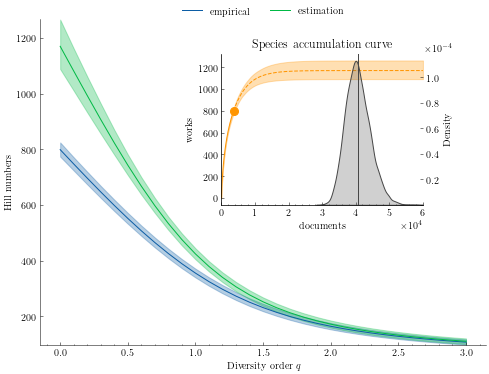

In [17]:
left, bottom, width, height = [0.44, 0.45, 0.35, 0.35]
fig, ax = plt.subplots(figsize=(8, 6))

hill_plot(emp, est, add_densities=False, ax=ax)
ax2 = fig.add_axes([left, bottom, width, height])

accumulation_curve(abundance, accumulation, c0='C2', c1='C5',
                   xlabel='documents', ylabel='works',
                   title='Species accumulation curve', ax=ax2,
                   minsample=minsample_est, xlim=(0, max_steps))
ax2.tick_params(axis='y', which='minor', left=False)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)

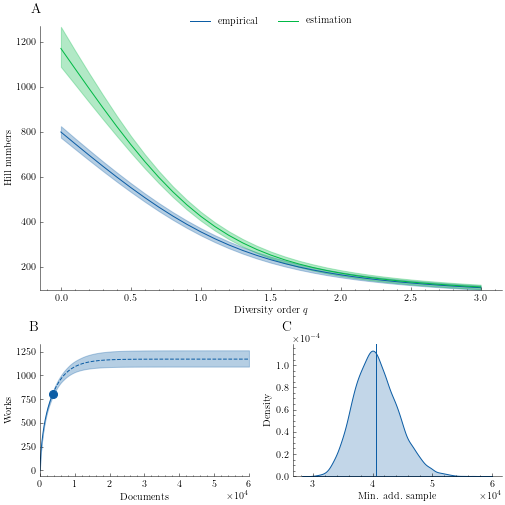

In [18]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(7, 7))
nrows, ncols = 3, 2
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

ax = plt.subplot(gspec[:2, :2])
hill_plot(emp, est, add_densities=False, ax=ax)
ax.text(-0.02, 1.05, "A", transform=ax.transAxes, fontweight='bold', fontsize=14)

ax2 = plt.subplot(gspec[2, 0])
accumulation_curve(abundance, accumulation, c0='C0', c1='C0',
                   xlabel='Documents', ylabel='works',
                   title=None, ax=ax2,
                   xlim=(0, max_steps))
ax2.tick_params(axis='y', which='minor', left=False)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
ax2.set_ylabel("Works")
ax2.text(-0.05, 1.1, "B", transform=ax2.transAxes, fontweight='bold', fontsize=14)

ax3 = plt.subplot(gspec[2, 1])
sb.kdeplot(minsample_est['bootstrap'], ax=ax3, color="C0", fill=True)
ax3.axvline(minsample_est['richness'], color="C0")

ax3.set(xlabel='Min. add. sample')
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
ax3.tick_params(axis='y', which='minor', left=True)
ax3.text(-0.05, 1.1, "C", transform=ax3.transAxes, fontweight='bold', fontsize=14)

plt.savefig('../outputs/all_comb.pdf');

## Language-specific estimates

We now turn to the estimates for the individual vernaculars considered. We first convert the available counts data to abundance data:

In [19]:
assemblages = {}
for lit, df in lits.items():
    abundance = u.to_abundance(df['title'])
    assemblages[lit.title()] = abundance

Point estimates for the original diversity of these assemblages are straightforward to obtain:

In [20]:
for category, assemblage in assemblages.items():
    print('category:', category)
    print('  - original # works:', diversity(assemblage, method='chao1'))
    print('  - original # documents:', diversity(assemblage, method='minsample'))

category: Dutch
  - original # works: 152.41824044219254
  - original # documents: 2214.756047756048
category: English
  - original # works: 178.62357954545456
  - original # documents: 3620.006644006644
category: French
  - original # works: 414.72621472214144
  - original # documents: 27050.63947763948
category: German
  - original # works: 162.07391640866874
  - original # documents: 7483.8143958143955
category: Icelandic
  - original # works: 151.4542372881356
  - original # documents: 1744.74944974945
category: Irish
  - original # works: 231.98515219005196
  - original # documents: 2335.4753864753866


The survival ratios resulting from the bootstrap procedure can be calculated in the following way;

In [21]:
wsurvival = {}
for category, assemblage in assemblages.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1')

100%|██████████| 1000/1000 [00:00<00:00, 4916.20it/s]


`copia` offers two auxiliary functions to visualize and compare the (bootstrapped) results across multiple assemblages. First, using colored kernel-density estimates:

In [22]:
%matplotlib inline

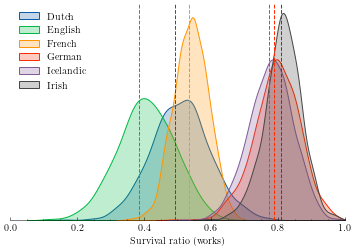

In [23]:
ax = multi_kde(wsurvival)
ax.legend(loc='upper left')
ax.set_xlabel('Survival ratio (works)')
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.spines['left'].set_visible(False)
plt.savefig('../outputs/survival_works_kde.pdf')

(Note how two clusters emerge.) Secondly, using error bars corresponding to the confidence intervals:

In [24]:
run ../../copia/copia/plot.py

<Figure size 432x288 with 0 Axes>

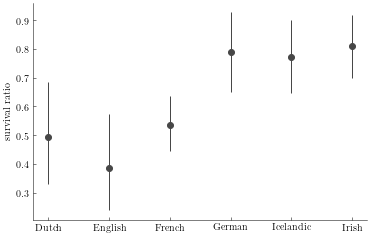

In [25]:
ax = survival_errorbar(wsurvival, ylabel="survival ratio")
ax.tick_params(axis='x', which='minor', bottom=False)
plt.savefig('../outputs/survival_works_error.pdf')

The previous cells were for the survival ratios of works; those for documents can be calculated and plotted analogously. Relatively speaking, the results for documents mirror those for the works.

In [26]:
dsurvival = {}
for category, assemblage in assemblages.items():
    dsurvival[category] = survival_ratio(assemblage, method='minsample')

100%|██████████| 1000/1000 [00:19<00:00, 50.18it/s]


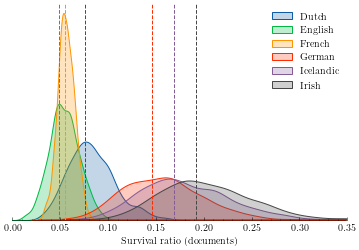

In [27]:
ax = multi_kde(dsurvival)
ax.legend(loc='upper right')
ax.set_xlim((0, 0.35))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Survival ratio (documents)')
plt.savefig('../outputs/survival_docs_kde.pdf')

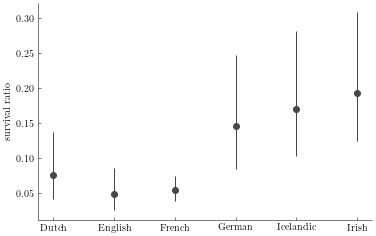

In [28]:
ax = survival_errorbar(dsurvival, ylabel="survival ratio")
ax.tick_params(axis='x', which='minor', bottom=False)
plt.savefig('../outputs/survival_docs_error.pdf')

We can now summarize the results for the language-specific estimation into a single overview table:

In [29]:
for c in 'CH1 CH1-lCI CH1-uCI MS MS-lCI MS-uCI'.split():
    stats_df[c] = 0.0

# for individual languages:
for lang in wsurvival:
    stats_df.loc[lang.lower(), 'CH1'] = wsurvival[lang]['survival']
    stats_df.loc[lang.lower(), 'CH1-lCI'] = wsurvival[lang]['lci']
    stats_df.loc[lang.lower(), 'CH1-uCI'] = wsurvival[lang]['uci']

for lang in dsurvival:
    stats_df.loc[lang.lower(), 'MS'] = dsurvival[lang]['survival']
    stats_df.loc[lang.lower(), 'MS-lCI'] = dsurvival[lang]['lci']
    stats_df.loc[lang.lower(), 'MS-uCI'] = dsurvival[lang]['uci']
    
# for union:
stats_df.loc['all', 'CH1'] = wsurvival_all['survival']
stats_df.loc['all', 'CH1-lCI'] = wsurvival_all['lci']
stats_df.loc['all', 'CH1-uCI'] = wsurvival_all['uci']

stats_df.loc['all', 'MS'] = dsurvival_all['survival']
stats_df.loc['all', 'MS-lCI'] = dsurvival_all['lci']
stats_df.loc['all', 'MS-uCI'] = dsurvival_all['uci']

stats_df.round(3)

,f1,f2,S,n,repo,CH1,CH1-lCI,CH1-uCI,MS,MS-lCI,MS-uCI
language,,,,,,,,,,,
dutch,45,13,75,167,80,0.492,0.331,0.685,0.075,0.041,0.136
english,42,8,69,176,36,0.386,0.239,0.572,0.049,0.025,0.086
french,90,21,222,1473,234,0.535,0.445,0.636,0.054,0.038,0.074
german,36,19,128,1088,389,0.790,0.650,0.927,0.145,0.083,0.247
icelandic,44,28,117,295,12,0.773,0.648,0.899,0.169,0.102,0.282
irish,69,54,188,449,15,0.810,0.698,0.917,0.192,0.123,0.308
all,326,143,799,3648,None,0.683,0.630,0.735,0.090,0.075,0.107


The cell below dumps the result to a Latex table for inclusion in the paper:

In [30]:
with open('../outputs/results.txt', 'w') as f:
    f.write(stats_df.round(3).to_latex())

### Evenness

For plotting the evenness profiles, we first need to calculate the (estimated, reconstructed) Hill number profile for each of the languages:

In [31]:
hill_est = {}
for lang, assemblage in assemblages.items():
    emp, est = hill_numbers(assemblage, n_iter=10000)
    hill_est[lang] = est

100%|██████████| 10000/10000 [04:34<00:00, 36.42it/s]


We can compute the (normalized) evenness profiles on the basis of the Hill number profiles:

In [32]:
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

Plotting these in a single graph can be done through calling the associated auxiliary function:

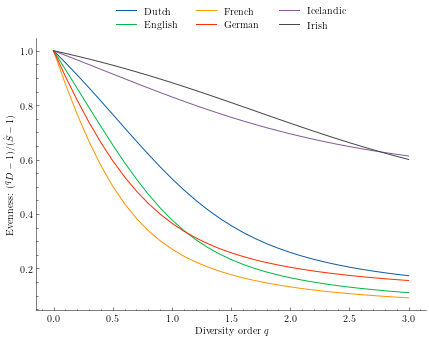

In [33]:
ax = evenness_plot(evennesses, figsize=(7, 5))
ax.tick_params(axis='y', which='minor', left=True)
lines, labels = ax.get_legend_handles_labels()
ax.set_title(None)
ax.legend(lines, labels, loc = 'upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), frameon=False)
plt.savefig('../outputs/evenness.pdf')

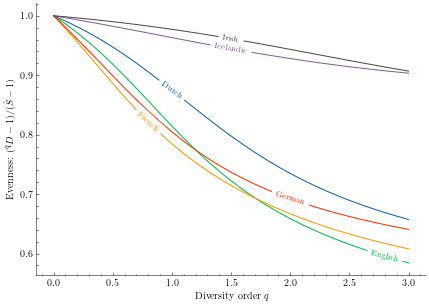

In [47]:
ax = evenness_plot(evennesses, figsize=(7, 5))
ax.tick_params(axis='y', which='minor', left=True)
lines, labels = ax.get_legend_handles_labels()
ax.set_title(None)
# ax.legend(lines, labels, loc = 'upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), frameon=False)
ax.get_legend().remove()

qs = np.arange(0, 3.1, 0.1)

ax.text(qs[10], evennesses['Dutch'][10], " " + "Dutch",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C0", ha="center", va="center", rotation=-35.5)

ax.text(qs[28], evennesses['English'][28], " " + "English",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C1", ha="center", va="center", rotation=-13.5)

ax.text(qs[8], evennesses['French'][8], " " + "French",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C2", ha="center", va="center", rotation=-42.5)

ax.text(qs[20], evennesses['German'][20], " " + "German",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C3", ha="center", va="center", rotation=-16.5)

ax.text(qs[15], evennesses['Irish'][15], " " + "Irish",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C5", ha="center", va="center", rotation=-9.5)

ax.text(qs[15], evennesses['Icelandic'][15], " " + "Icelandic",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C4", ha="center", va="center", rotation=-9.5)

plt.savefig('../outputs/evenness-inset-text.pdf')

We can repeat this for the other classes of evenness measures ($E_1$-$E_5$):

/Users/mikekestemont/GitRepos/copia/copia/utils.py:230: RuntimeWarning: invalid value encountered in true_divide
  (1 - (d['richness'][0] ** qs)))
/Users/mikekestemont/GitRepos/copia/copia/utils.py:230: RuntimeWarning: invalid value encountered in true_divide
  (1 - (d['richness'][0] ** qs)))


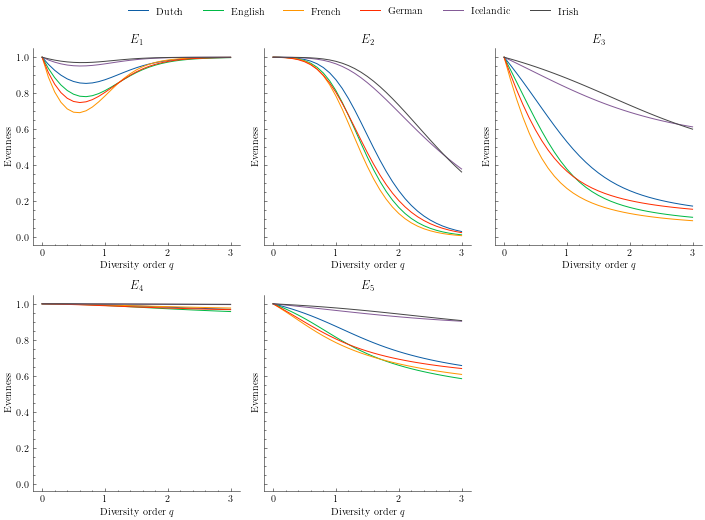

In [35]:
import matplotlib.pyplot as plt


from matplotlib.lines import Line2D

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), sharey=True)
axes = axes.flatten()

for i in range(1, 6):
    evennesses = {l:evenness(hill_est[l], E=i) for l in hill_est}
    ax = evenness_plot(evennesses, xlabel="Diversity order $q$", ylabel="Evenness", ax=axes[i-1])
    ax.set_title(f"$E_{i}$")
    ax.tick_params(axis='y', which='minor', left=True)
    ax.get_legend().remove()
axes[-1].remove()  # don't display empty ax

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center', ncol=6, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.tight_layout()

plt.savefig(f"../outputs/evenness-plots.pdf", bbox_inches='tight')

## Anglo-Norman

Because the scores for Middle English are so (extremely) low, it is worth investigating the ffect of complementing the English data with abundance data from Anglo-Norman literature. We can load this data, ignored above, as follows:

In [36]:
an_fn = '../datasets/master/anglo-norman.xlsx'
an = pd.read_excel(an_fn, engine='openpyxl').dropna(subset = ["title"])
an = an[['title', 'signature']]
an

,title,signature
0,Romance of Horn,"Cambridge, CUL, Ff.vi.17"
1,Romance of Horn,"Cambridge, CUL, Add. 4407"
2,Romance of Horn,"Cambridge, CUL, Add. 4470"
3,Romance of Horn,"London, British Library, Harley 527"
4,Romance of Horn,"Oxford, Bodleian Library, Douce 132"
...,...,...
58,Gormont et Isembart,"Brussels, Bibl. Roy., portefeuille II.181"
59,La destructioun de Rome,"Hannover, Niedersachsische Landesbibl., IV.578"
60,La destructioun de Rome,"London, British Library, Egerton 3028"
61,Fierabras,"Hannover, Niedersachsische Landesbibl., IV.578"


In the cell below, we repeat some of the basic analyses above for the estimating the works diversity of the combined Middle English and Anglo-Norman data.

In [37]:
comp = {'English': assemblages['English'],
        'English with Anglo-Norman': np.concatenate((assemblages['English'],
                                                 u.to_abundance(an['title'])))
       }

wsurvival = {}
for category, assemblage in comp.items():
    wsurvival[category] = survival_ratio(assemblage, method='chao1', n_iter=10000)

100%|██████████| 10000/10000 [00:01<00:00, 8968.29it/s]


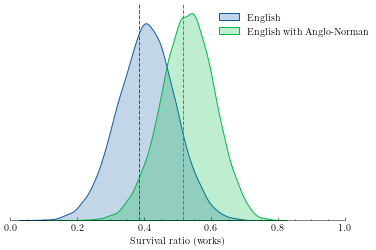

In [38]:
ax = multi_kde(wsurvival, figsize=(6, 4))
ax.legend(loc='center right', bbox_to_anchor=(1.1, 0.9))
ax.set_xlabel('Survival ratio (works)')
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.spines['left'].set_visible(False)
plt.savefig('../outputs/anglonorman.pdf');

In [39]:
for cat, res in wsurvival.items():
    print(f'{cat}: {round(res["survival"], 3)} [{round(res["lci"], 3)}-{round(res["uci"], 3)}]')

English: 0.386 [0.236-0.574]
English with Anglo-Norman: 0.516 [0.367-0.679]


## Additional estimators

In the paper, we focus on Chao1, which is an established and robust method in ecology. It is useful to compare the results, however, to a number of additional estimators for the work survival. From `copia`, the following alternatives are available:
- the higher-order **Jackknife**: a more general method for bias-correction in statistics
- **iChao1**: an variant of Chao1, that also takes into account $f_3$ and $f_4$
- the **Egghe & Proot** estimator, using the default setting of `alpha=150`.

In [40]:
comp = []

for estimator in ['chao1', 'jackknife', 'ichao1', 'egghe_proot']:
    for category, assemblage in assemblages.items():
        surv = survival_ratio(assemblage, method=estimator, n_iter=10000)
        comp.append([category, estimator, surv['survival'], surv['lci'], surv['uci']])
        
comp = pd.DataFrame(comp, columns=['tradition', 'estimator', 'survival', 'lci', 'uci'])

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|          | 6/10000 [00:00<03:41, 45.14it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
 24%|██▍       | 2417/10000 [00:00<00:01, 6983.65it/s]/Users/mikekestemont/GitRepos/copia/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
100%|██████████| 10000/10000 [00:01<00:00, 9261.20it/s]


In [41]:
estimates = comp.sort_values(['tradition', 'estimator'])
estimates

,tradition,estimator,survival,lci,uci
0,Dutch,chao1,0.492067,0.335334,0.678618
18,Dutch,egghe_proot,0.440399,0.282460,0.644328
12,Dutch,ichao1,0.437208,0.293930,0.612341
6,Dutch,jackknife,0.423729,0.331573,0.586830
1,English,chao1,0.386287,0.235544,0.571569
19,English,egghe_proot,0.318201,0.185235,0.490136
13,English,ichao1,0.366780,0.221268,0.560066
7,English,jackknife,0.338235,0.254306,0.504855
2,French,chao1,0.535293,0.433677,0.639719
20,French,egghe_proot,0.374413,0.287216,0.469109


In [42]:
estimates["estimator"] = estimates["estimator"].str.replace("_", " ")

In [43]:
with open('../outputs/other.txt', 'w') as f:
    f.write(estimates.round(3).to_latex())

We can visualize these results using a bar plot to obtain a better overview:

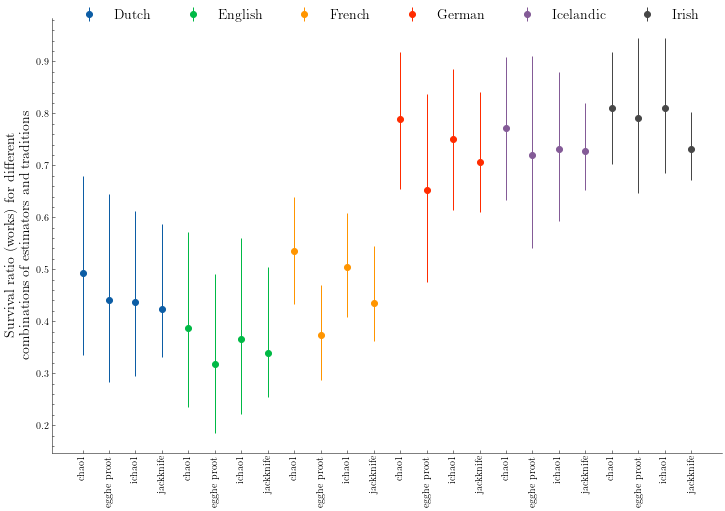

In [44]:
errors = np.array(list(zip(estimates['lci'], estimates['uci']))).T
errors[0] = estimates['survival'] - errors[0]
errors[1] -= estimates['survival']

fig, ax = plt.subplots(figsize=(12, 8))

traditions = sorted(set(estimates['tradition']))
color_dict = {t: f"C{i}" for i, t in enumerate(traditions)}
labeled = {t:False for t in color_dict}

for idx in range(len(estimates)):
    trad = estimates['tradition'].iloc[idx]
    meth = estimates['estimator'].iloc[idx]
    label = trad if not labeled[trad] else None
    c = color_dict[trad]
    labeled[trad] = True
    ax.errorbar(idx, estimates['survival'].iloc[idx],
        yerr=np.array([errors[:, idx]]).T,
        fmt='.', c=color_dict[trad], label=label,
        ms=12)


ax.set_ylabel('Survival ratio (works) for different\ncombinations of estimators and traditions', fontsize=14)
ax.set_xticks(np.arange(len(estimates)))
ax.set_xticklabels(estimates['estimator'], rotation = 90)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=True)
ax.legend(loc='upper center', ncol=len(assemblages), bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=14)

plt.savefig('../outputs/other.pdf');

As can be seen, the methods show differences but are largely in agreement. The overall difference is confirmed, between the relatively lower survival rates for Dutch, English, and French, as opposed to the considerably higher survival rates for German, Icelandic and Irish.